In [1]:
# Define experiment parameters
year = "201516"
target_col = "has_occ"  # 'white_collar', 'blue_collar', 'has_occ'
sample_weight_col = 'women_weight'

In [2]:
# Define resource utilization parameters
random_state = 42
n_jobs_clf = 16
n_jobs_cv = 4
cv_folds = 5

In [3]:
import numpy as np
np.random.seed(random_state)

import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pylab as pl

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.utils.class_weight import compute_class_weight

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import shap

import pickle
from joblib import dump, load

---

# Prepare Dataset

In [4]:
# Load dataset
dataset = pd.read_csv(f"data/women_work_data_{year}.csv")
print("Loaded dataset: ", dataset.shape)
dataset.head()

Loaded dataset:  (111398, 26)


Unnamed: 0  case_id_str  line_no country_code  cluster_no  hh_no  \
0           8    1000117.0        2          IA6       10001     17   
1           9    1000120.0        1          IA6       10001     20   
2          11    1000129.0        2          IA6       10001     29   
3          12    1000129.0        3          IA6       10001     29   
4          13    1000130.0        2          IA6       10001     30   

                         state wealth_index hh_religion                 caste  \
0  andaman and nicobar islands       middle       hindu                   NaN   
1  andaman and nicobar islands       richer       hindu         none of above   
2  andaman and nicobar islands      richest      muslim  other backward class   
3  andaman and nicobar islands      richest      muslim  other backward class   
4  andaman and nicobar islands       richer   christian       scheduled caste   

   women_weight  women_anemic  obese_female  urban  freq_tv   age  occupation  \
0      0.191636           1.0           0.0    1.0      3.0  23.0         0.0   
1      0.191636           0.0           0.0    1.0      3.0  35.0         8.0   
2      0.191636           1.0           0.0    1.0      3.0  46.0         0.0   
3      0.191636           1.0           0.0    1.0      3.0  17.0         0.0   
4      0.191636           1.0           1.0    1.0      3.0  30.0         0.0   

   years_edu  hh_members  no_children_below5  white_collar  blue_collar  \
0       10.0         2.0                 0.0           0.0          0.0   
1        8.0         3.0                 0.0           0.0          1.0   
2       12.0         3.0                 0.0           0.0          0.0   
3       11.0         3.0                 0.0           0.0          0.0   
4        8.0         5.0                 0.0           0.0          0.0   

   no_occ  has_occ    year  total_children  
0     1.0      0.0  2015.0             0.0  
1     0.0      1.0  2015.0             2.0  
2     1.0      0.0  2015.0             2.0  
3     1.0      0.0  2015.0             0.0  
4     1.0      0.0  2015.0             3.0

In [5]:
# See distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0.0    77560
1.0    33838
Name: has_occ, dtype: int64


In [6]:
# Drop samples where the target is missing
dataset.dropna(axis=0, subset=[target_col, sample_weight_col], inplace=True)
print("Drop missing targets: ", dataset.shape)

Drop missing targets:  (111398, 26)


In [7]:
# Drop samples where age < 21
dataset = dataset[dataset['age'] >= 21]
print("Drop under-21 samples: ", dataset.shape)

Drop under-21 samples:  (86825, 26)


In [8]:
# See new distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0.0    57686
1.0    29139
Name: has_occ, dtype: int64


In [9]:
# Post-processing

# Group SC/ST castes together
dataset['caste'][dataset['caste'] == 'scheduled caste'] = 'sc/st'
dataset['caste'][dataset['caste'] == 'scheduled tribe'] = 'sc/st'
if year == "200506":
    dataset['caste'][dataset['caste'] == '9'] = "don\'t know"

# Fix naming for General caste
dataset['caste'][dataset['caste'] == 'none of above'] = 'general'

if year == "201516":
    # Convert wealth index from str to int values
    wi_dict = {'poorest': 0, 'poorer': 1, 'middle': 2, 'richer': 3, 'richest': 4}
    dataset['wealth_index'] = [wi_dict[wi] for wi in dataset['wealth_index']]

/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# Define feature columns
x_cols_categorical = ['state', 'hh_religion', 'caste']
x_cols_binary = ['urban', 'women_anemic', 'obese_female']
x_cols_numeric = ['age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']
x_cols = x_cols_categorical + x_cols_binary + x_cols_numeric
print("Feature columns:\n", x_cols)

Feature columns:
 ['state', 'hh_religion', 'caste', 'urban', 'women_anemic', 'obese_female', 'age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']


In [11]:
# Drop samples with missing values in feature columns
dataset.dropna(axis=0, subset=x_cols, inplace=True)
print("Drop missing feature value rows: ", dataset.shape)

Drop missing feature value rows:  (81816, 26)


In [12]:
# Separate target column
targets = dataset[target_col]
# Separate sampling weight column
sample_weights = dataset[sample_weight_col]
# Drop columns which are not part of features
dataset.drop(columns=[col for col in dataset.columns if col not in x_cols], axis=1, inplace=True)
print("Drop extra columns: ", dataset.shape)

Drop extra columns:  (81816, 13)


In [13]:
# Obtain one-hot encodings for the caste column
dataset = pd.get_dummies(dataset, columns=['caste'])
x_cols_categorical.remove('caste')  # Remove 'caste' from categorical variables list
print("Caste to one-hot: ", dataset.shape)

Caste to one-hot:  (81816, 16)


In [14]:
dataset_display = dataset.copy()
dataset_display.columns = ['State', 'Wealth Index', 'Hh. Religion', 'Anemic', 'Obese',
                           'Residence Type', 'Freq. of TV', 'Age', 'Yrs. of Education', 'Hh. Members',
                           'Children Below 5', 'Total Children', 'Unknown Caste',
                           'General Caste', 'OBC Caste', 'Sc/St Caste']
print("Create copy for visualization: ", dataset_display.shape)
dataset_display.head()

Create copy for visualization:  (81816, 16)


State  Wealth Index Hh. Religion  Anemic  Obese  \
1  andaman and nicobar islands             3        hindu     0.0    0.0   
2  andaman and nicobar islands             4       muslim     1.0    0.0   
4  andaman and nicobar islands             3    christian     1.0    1.0   
5  andaman and nicobar islands             3    christian     1.0    0.0   
7  andaman and nicobar islands             4        hindu     1.0    1.0   

   Residence Type  Freq. of TV   Age  Yrs. of Education  Hh. Members  \
1             1.0          3.0  35.0                8.0          3.0   
2             1.0          3.0  46.0               12.0          3.0   
4             1.0          3.0  30.0                8.0          5.0   
5             1.0          3.0  21.0               12.0          5.0   
7             1.0          3.0  40.0                8.0          2.0   

   Children Below 5  Total Children  Unknown Caste  General Caste  OBC Caste  \
1               0.0             2.0              0              1          0   
2               0.0             2.0              0              0          1   
4               0.0             3.0              0              0          0   
5               0.0             0.0              0              0          0   
7               0.0             2.0              0              1          0   

   Sc/St Caste  
1            0  
2            0  
4            1  
5            1  
7            0

In [15]:
# Obtain integer encodings for other categorical features
for col in x_cols_categorical:
    dataset[col] = pd.factorize(dataset[col])[0]
print("Categoricals to int encodings: ", dataset.shape)

Categoricals to int encodings:  (81816, 16)


In [16]:
dataset.head()

state  wealth_index  hh_religion  women_anemic  obese_female  urban  \
1      0             3            0           0.0           0.0    1.0   
2      0             4            1           1.0           0.0    1.0   
4      0             3            2           1.0           1.0    1.0   
5      0             3            2           1.0           0.0    1.0   
7      0             4            0           1.0           1.0    1.0   

   freq_tv   age  years_edu  hh_members  no_children_below5  total_children  \
1      3.0  35.0        8.0         3.0                 0.0             2.0   
2      3.0  46.0       12.0         3.0                 0.0             2.0   
4      3.0  30.0        8.0         5.0                 0.0             3.0   
5      3.0  21.0       12.0         5.0                 0.0             0.0   
7      3.0  40.0        8.0         2.0                 0.0             2.0   

   caste_don't know  caste_general  caste_other backward class  caste_sc/st  
1                 0              1                           0            0  
2                 0              0                           1            0  
4                 0              0                           0            1  
5                 0              0                           0            1  
7                 0              1                           0            0

In [17]:
# Create Training, Validation and Test sets
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(dataset, targets, sample_weights, test_size=0.05, random_state=random_state, stratify=targets)
# X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(X_train, Y_train, W_train, test_size=0.1)
print("Training set: ", X_train.shape, Y_train.shape, W_train.shape)
# print("Validation set: ", X_val.shape, Y_val.shape, W_val.shape)
print("Test set: ", X_test.shape, Y_test.shape, W_test.shape)
train_cw = compute_class_weight("balanced", classes=np.unique(Y_train), y=Y_train)
print("Class weights: ", train_cw)

Training set:  (77725, 16) (77725,) (77725,)
Test set:  (4091, 16) (4091,) (4091,)
Class weights:  [0.75836667 1.46761707]


---

# Build LightGBM Classifier

In [18]:
# # Define LightGBM Classifier
# model = LGBMClassifier(boosting_type='gbdt', 
#                        feature_fraction=0.8,  
#                        learning_rate=0.01,
#                        max_bins=64,
#                        max_depth=-1,
#                        min_child_weight=0.001,
#                        min_data_in_leaf=50,
#                        min_split_gain=0.0,
#                        num_iterations=1000,
#                        num_leaves=64,
#                        reg_alpha=0,
#                        reg_lambda=1,
#                        subsample_for_bin=200000,
#                        is_unbalance=True,
#                        random_state=random_state, 
#                        n_jobs=n_jobs_clf, 
#                        silent=True, 
#                        importance_type='split')

In [19]:
# # Fit model on training set
# model.fit(X_train, Y_train, sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

In [20]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [21]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-model.joblib')
# del model

### Hyperparameter Search

In [22]:
# # Define hyperparameter grid
# param_grid = {
#     'num_leaves': [8, 32, 64],
#     'min_data_in_leaf': [10, 20, 50],
#     'max_depth': [-1], 
#     'learning_rate': [0.01, 0.1], 
#     'num_iterations': [1000, 3000, 5000], 
#     'subsample_for_bin': [200000],
#     'min_split_gain': [0.0], 
#     'min_child_weight': [0.001],
#     'feature_fraction': [0.8, 1.0], 
#     'reg_alpha': [0], 
#     'reg_lambda': [0, 1],
#     'max_bin': [64, 128, 255]
# }

In [23]:
# # Define LightGBM Classifier
# clf = LGBMClassifier(boosting_type='gbdt',
#                      objective='binary', 
#                      is_unbalance=True,
#                      random_state=random_state,
#                      n_jobs=n_jobs_clf, 
#                      silent=True, 
#                      importance_type='split')

# # Define K-fold cross validation splitter
# kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# # Perform grid search
# model = GridSearchCV(clf, param_grid=param_grid, scoring='f1', n_jobs=n_jobs_cv, cv=kfold, refit=True, verbose=3)
# model.fit(X_train, Y_train, 
#           sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

# print('\n All results:')
# print(model.cv_results_)
# print('\n Best estimator:')
# print(model.best_estimator_)
# print('\n Best hyperparameters:')
# print(model.best_params_)

In [24]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions, average='micro'))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [25]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-gridsearch.joblib')
# del model

---

# Load LightGBM Classifier

In [26]:
model = load(f'models/{target_col}-{year}-model.joblib')
# model = load(f'models/{target_col}-{year}-gridsearch.joblib').best_estimator_

In [27]:
# Sanity check: Make predictions on Test set
predictions = model.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(f1_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.6731850403324371
0.5781003471126539
[[1838  859]
 [ 478  916]]
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73      2697
         1.0       0.52      0.66      0.58      1394

   micro avg       0.67      0.67      0.67      4091
   macro avg       0.65      0.67      0.66      4091
weighted avg       0.70      0.67      0.68      4091



In [28]:
# Overfitting check: Make predictions on Train set
predictions = model.predict(X_train)
print(accuracy_score(Y_train, predictions))
print(f1_score(Y_train, predictions))
print(confusion_matrix(Y_train, predictions))
print(classification_report(Y_train, predictions))

0.6920553232550659
0.604478228538379
[[35500 15745]
 [ 8190 18290]]
              precision    recall  f1-score   support

         0.0       0.81      0.69      0.75     51245
         1.0       0.54      0.69      0.60     26480

   micro avg       0.69      0.69      0.69     77725
   macro avg       0.67      0.69      0.68     77725
weighted avg       0.72      0.69      0.70     77725



---

# Visualizations/Explainations
- Reference: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- Github: https://github.com/slundberg/shap

**Note that these plot just explain how the XGBoost model works, not nessecarily how reality works.** Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

In [29]:
# print the JS visualization code to the notebook
shap.initjs()

### What makes a measure of feature importance good or bad?

1. Consistency: Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
2. Accuracy. The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

**If consistency fails to hold, then we can’t compare the attributed feature importances between any two models**, because then having a higher assigned attribution doesn’t mean the model actually relies more on that feature.

**If accuracy fails to hold then we don’t know how the attributions of each feature combine to represent the output of the whole model.** We can’t just normalize the attributions after the method is done since this might break the consistency of the method.

### Using Tree SHAP for interpretting the model 

In [30]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(dataset)
shap_values = pickle.load(open(f'res/{target_col}-{year}-shapvals.obj', 'rb'))

In [31]:
# Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], dataset_display.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. **Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.**

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [32]:
# Visualize many predictions
subsample = np.random.choice(len(dataset), 1000)  # Take random sub-sample
shap.force_plot(explainer.expected_value, shap_values[subsample,:], dataset_display.iloc[subsample,:])

## Summary Plots

In [33]:
for col, sv in zip(dataset.columns, np.abs(shap_values).mean(0)):
    print(f"{col} - {sv}")

state - 0.33070504018404656
wealth_index - 0.253203333450433
hh_religion - 0.09826029558285404
women_anemic - 0.015395294773752708
obese_female - 0.07340479598166229
urban - 0.060820406381605456
freq_tv - 0.05723673707790526
age - 0.21288720592527663
years_edu - 0.18289803463472182
hh_members - 0.049856948967428746
no_children_below5 - 0.12782162963724114
total_children - 0.08762008139480229
caste_don't know - 0.00036079969215569645
caste_general - 0.06690355821098182
caste_other backward class - 0.009496575625847478
caste_sc/st - 0.1153496534490254


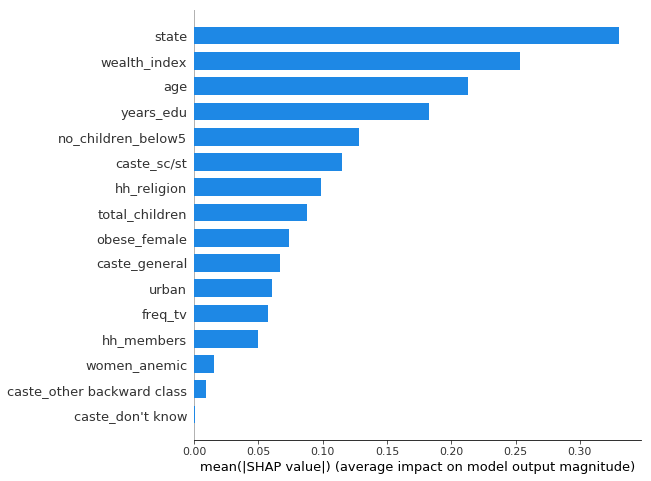

In [34]:
shap.summary_plot(shap_values, dataset, plot_type="bar")

The above figure shows the global mean(|Tree SHAP|) method applied to our model. 

**The x-axis is essentially the average magnitude change in model output when a feature is “hidden” from the model (for this model the output has log-odds units).** “Hidden” means integrating the variable out of the model. Since the impact of hiding a feature changes depending on what other features are also hidden, Shapley values are used to enforce consistency and accuracy.

However, since we now have individualized explanations for every person in our dataset, to get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low):

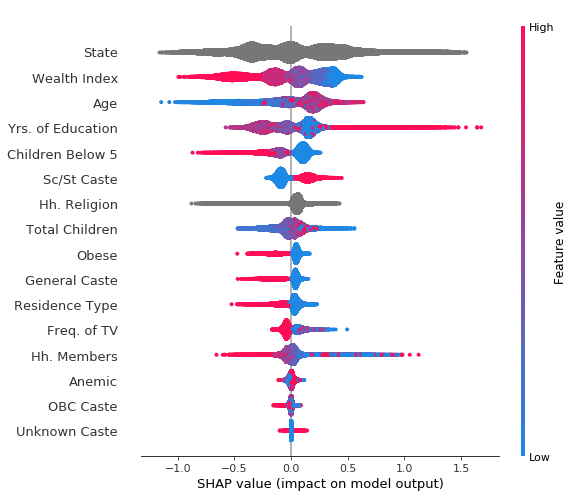

In [35]:
shap.summary_plot(shap_values, dataset_display)

- Every person has one dot on each row. 
- **The x position of the dot is the impact of that feature on the model’s prediction for the person.**
- **The color of the dot represents the value of that feature for the customer.** Categorical variables are colored grey.
- Dots that don’t fit on the row pile up to show density (since our dataset is large). 
- Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model).

**How to use this**: We can make analysis similar to [the blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for interpretting our models.

---

### SHAP Dependence Plots

Next, to understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP dependence plots show the effect of a single feature across the whole dataset. **They plot a feature's value vs. the SHAP value of that feature across many samples.** 

SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. **One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.**

Good example of using Dependency Plots: https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html

#### Plots for 'age'


Feature: age, Interaction Feature: age


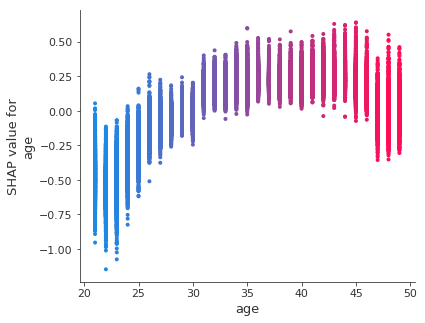


Feature: age, Interaction Feature: urban


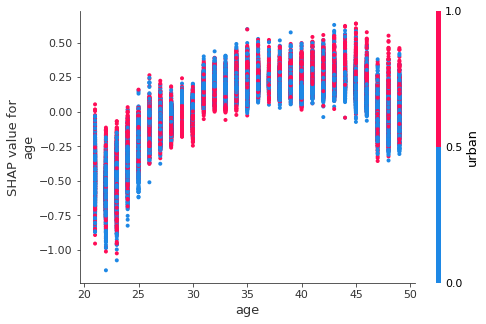


Feature: age, Interaction Feature: caste_sc/st


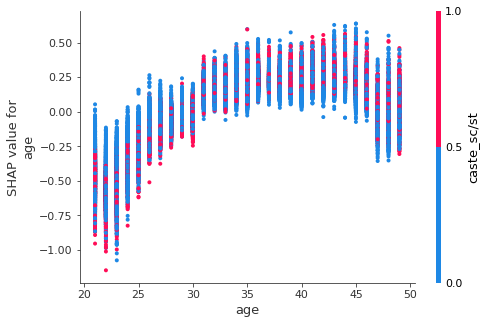


Feature: age, Interaction Feature: caste_general


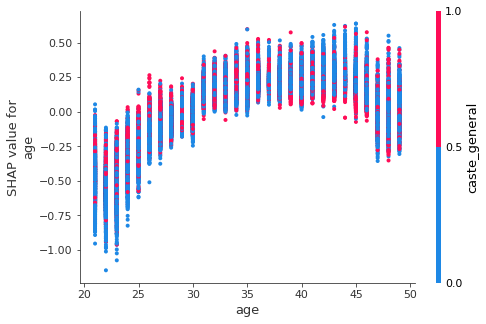


Feature: age, Interaction Feature: wealth_index


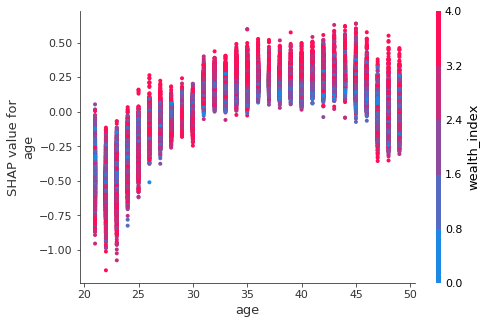


Feature: age, Interaction Feature: years_edu


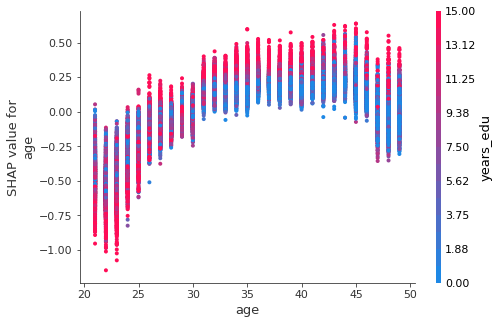


Feature: age, Interaction Feature: no_children_below5


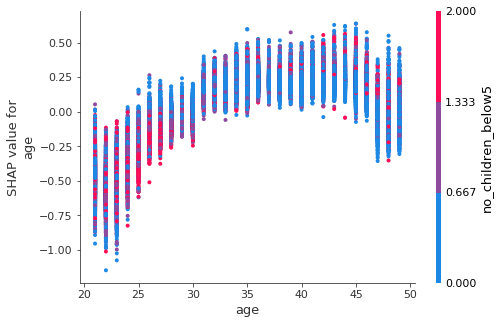


Feature: age, Interaction Feature: total_children


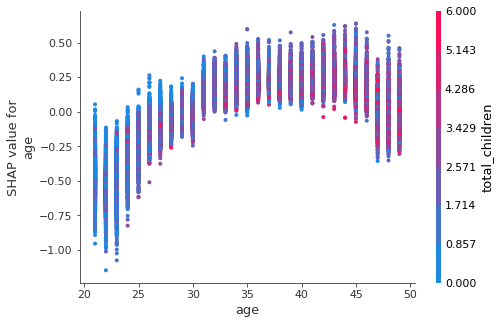


Feature: hh_religion, Interaction Feature: age


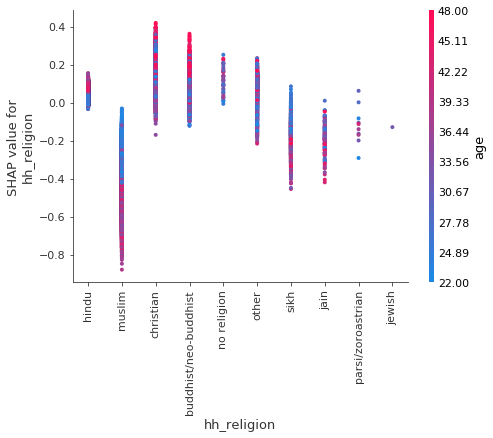


Feature: state, Interaction Feature: age


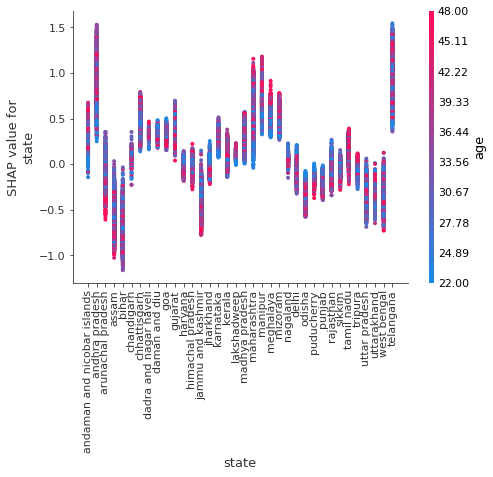

In [36]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children'),
         ('hh_religion', 'age'),
         ('state', 'age')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


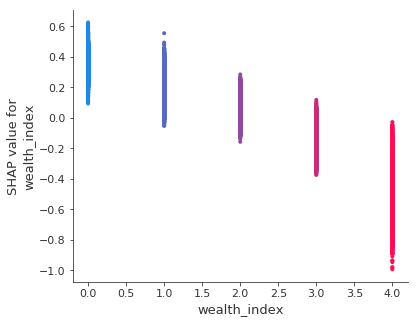


Feature: wealth_index, Interaction Feature: age


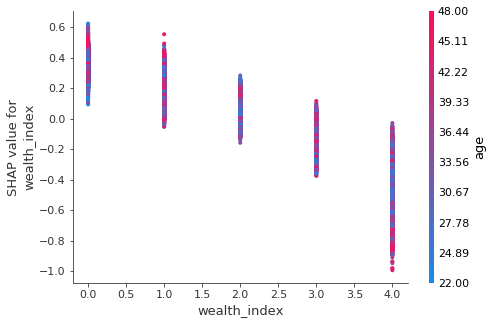


Feature: wealth_index, Interaction Feature: urban


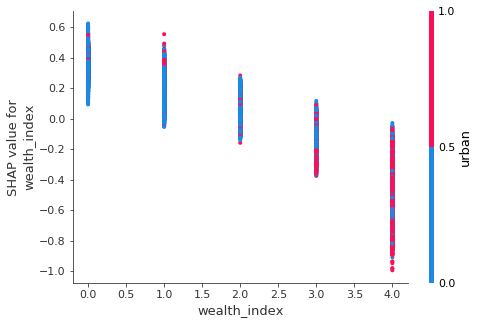


Feature: wealth_index, Interaction Feature: caste_sc/st


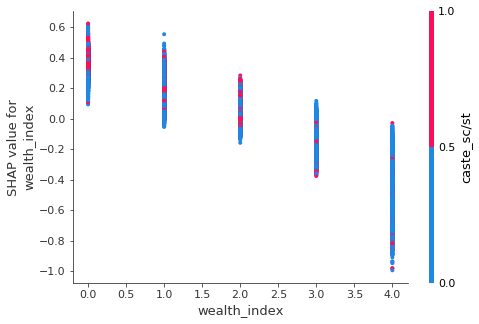


Feature: wealth_index, Interaction Feature: caste_general


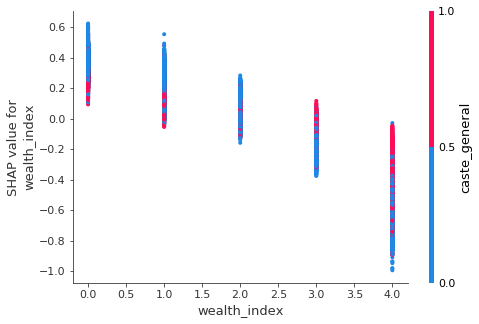


Feature: wealth_index, Interaction Feature: years_edu


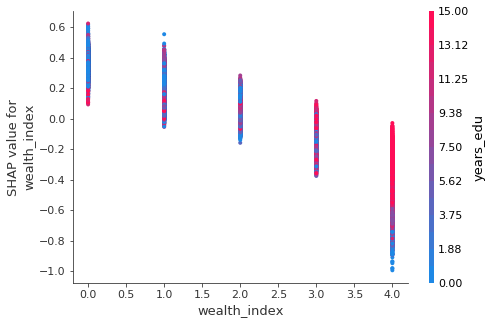


Feature: wealth_index, Interaction Feature: no_children_below5


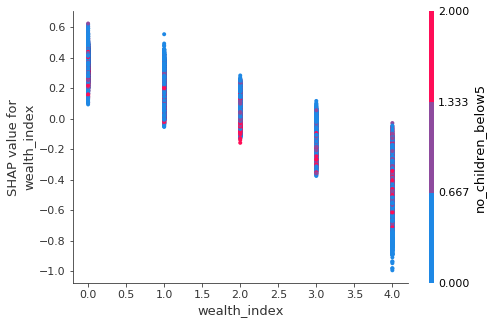


Feature: wealth_index, Interaction Feature: total_children


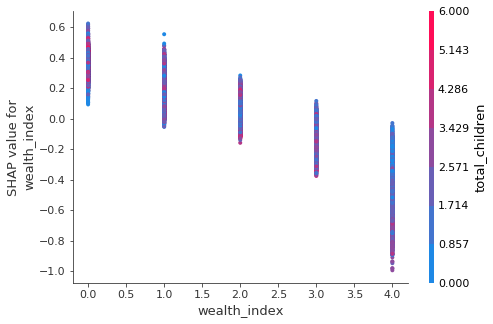


Feature: hh_religion, Interaction Feature: wealth_index


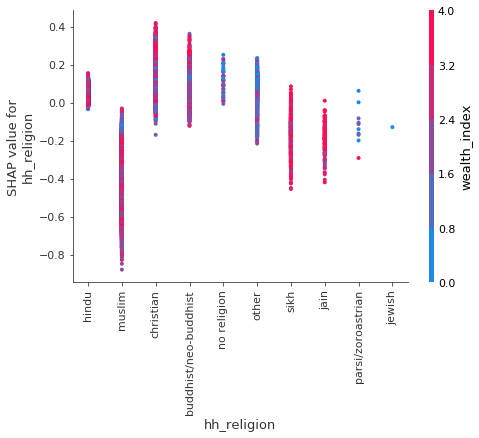


Feature: state, Interaction Feature: wealth_index


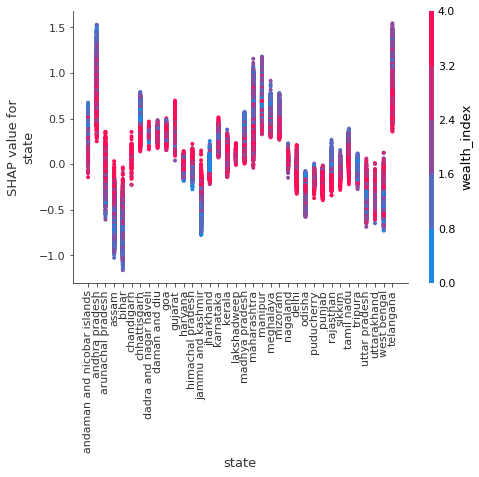

In [37]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children'),
         ('hh_religion', 'wealth_index'),
         ('state', 'wealth_index')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


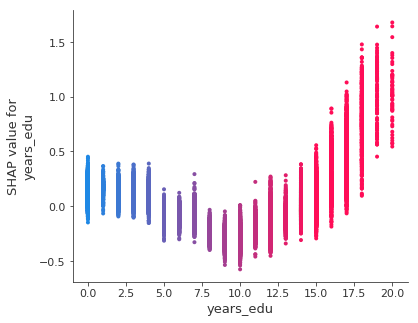


Feature: years_edu, Interaction Feature: age


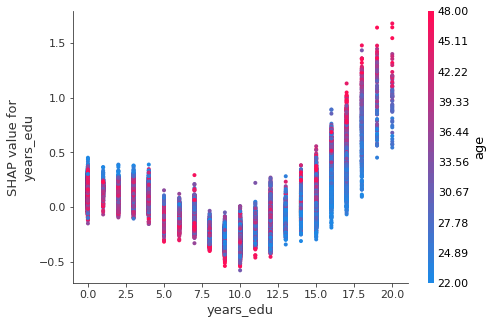


Feature: years_edu, Interaction Feature: urban


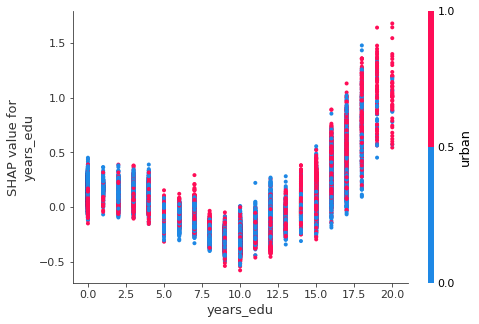


Feature: years_edu, Interaction Feature: caste_sc/st


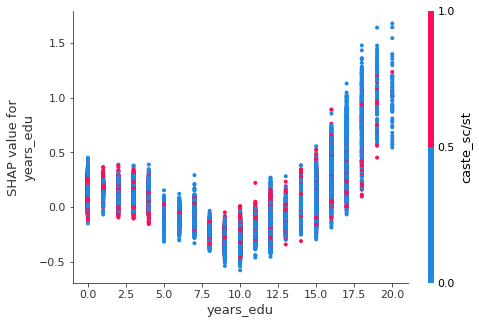


Feature: years_edu, Interaction Feature: caste_general


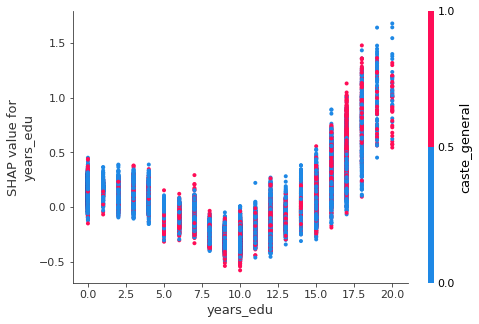


Feature: years_edu, Interaction Feature: wealth_index


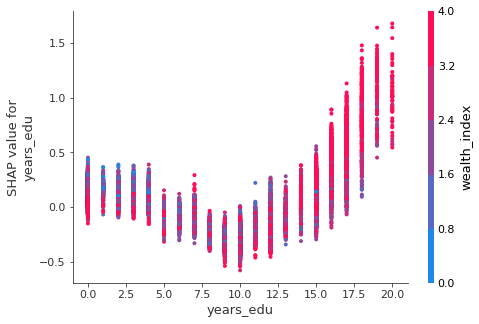


Feature: years_edu, Interaction Feature: no_children_below5


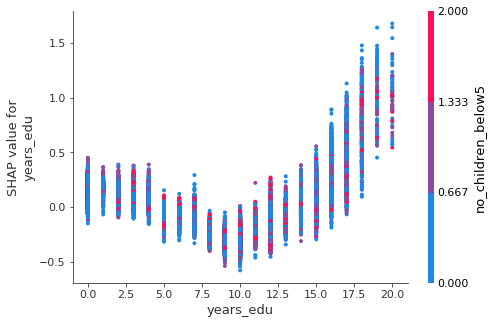


Feature: years_edu, Interaction Feature: total_children


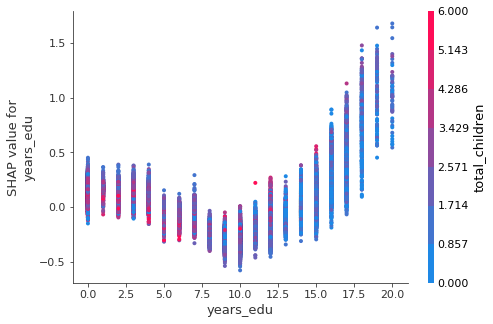


Feature: hh_religion, Interaction Feature: years_edu


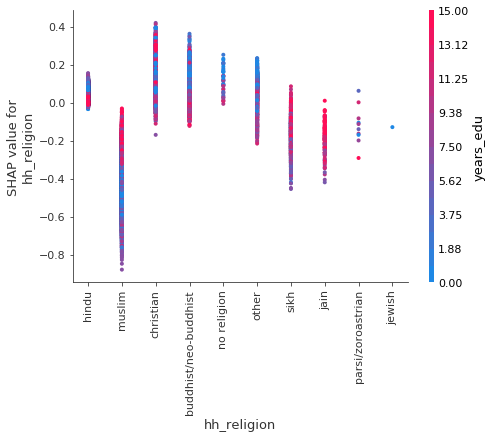


Feature: state, Interaction Feature: years_edu


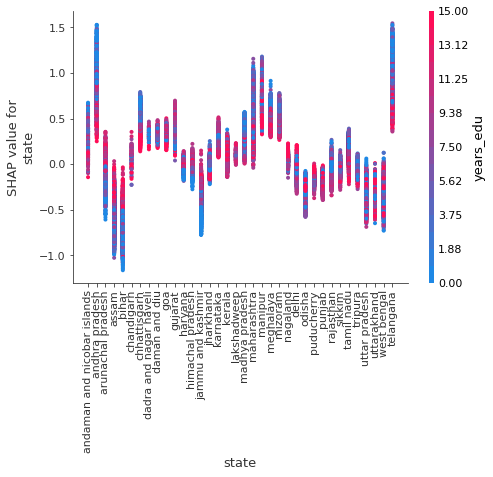

In [38]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children'),
         ('hh_religion', 'years_edu'),
         ('state', 'years_edu')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


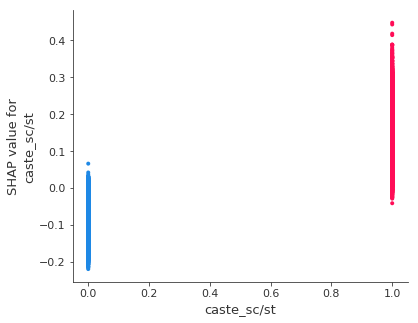


Feature: caste_sc/st, Interaction Feature: age


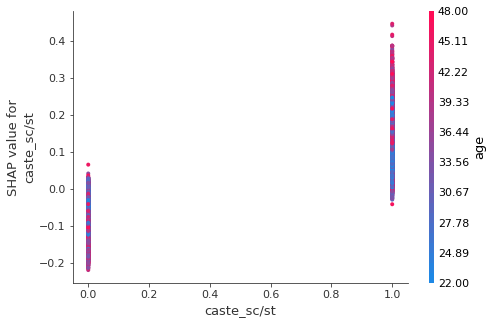


Feature: caste_sc/st, Interaction Feature: urban


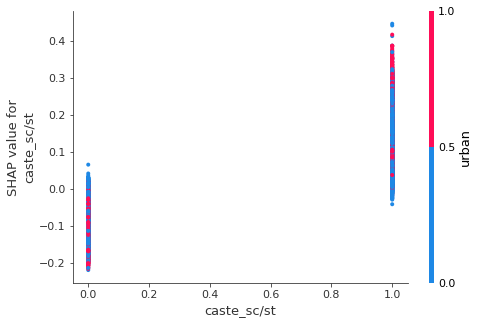


Feature: caste_sc/st, Interaction Feature: years_edu


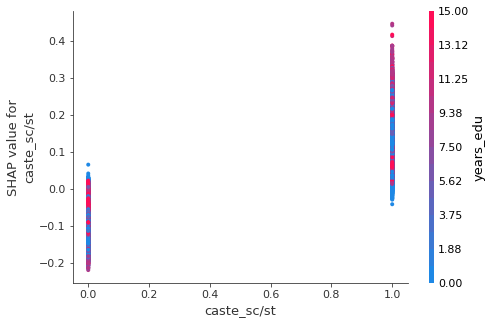


Feature: caste_sc/st, Interaction Feature: wealth_index


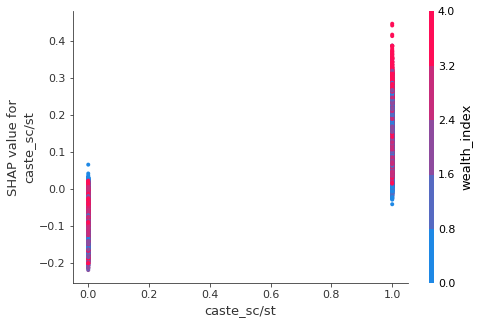


Feature: caste_sc/st, Interaction Feature: no_children_below5


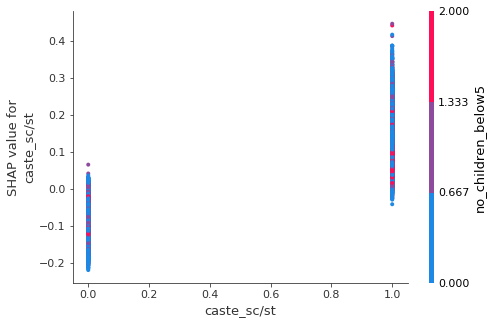


Feature: caste_sc/st, Interaction Feature: total_children


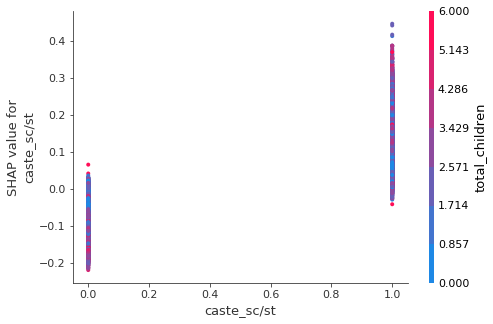


Feature: hh_religion, Interaction Feature: caste_sc/st


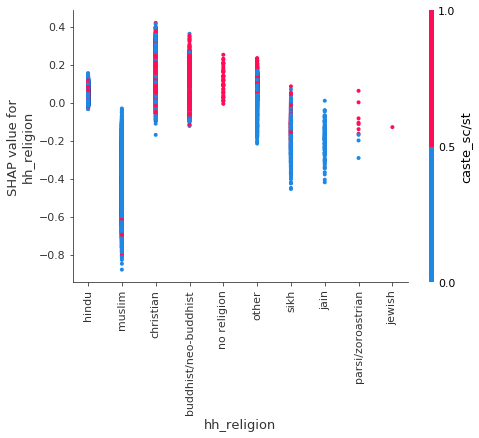


Feature: state, Interaction Feature: caste_sc/st


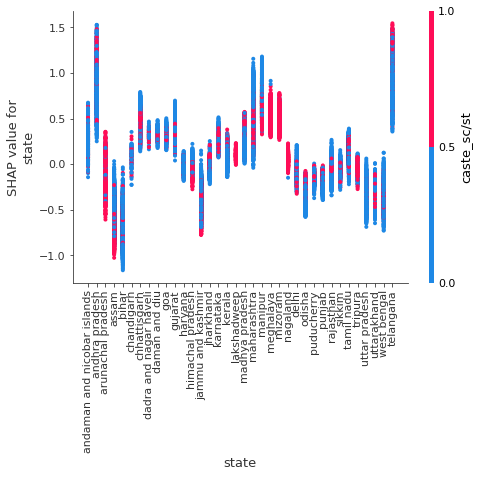

In [39]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children'),
         ('hh_religion', 'caste_sc/st'),
         ('state', 'caste_sc/st')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


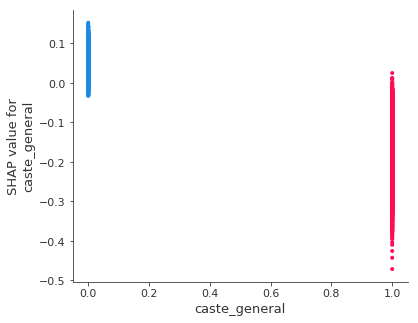


Feature: caste_general, Interaction Feature: age


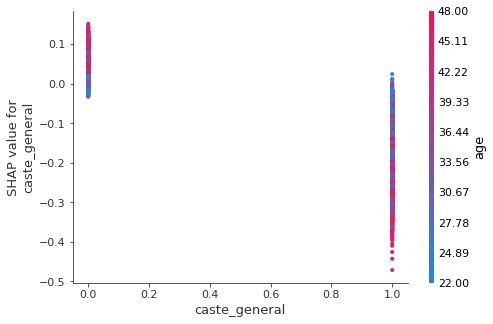


Feature: caste_general, Interaction Feature: urban


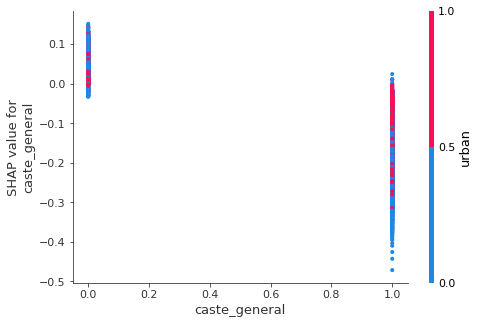


Feature: caste_general, Interaction Feature: years_edu


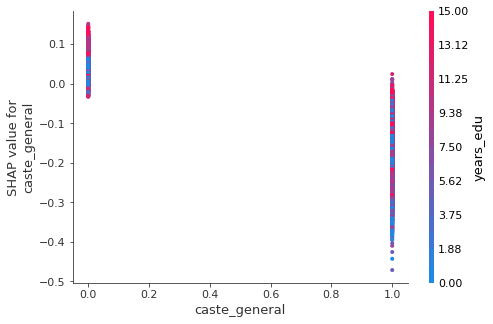


Feature: caste_general, Interaction Feature: wealth_index


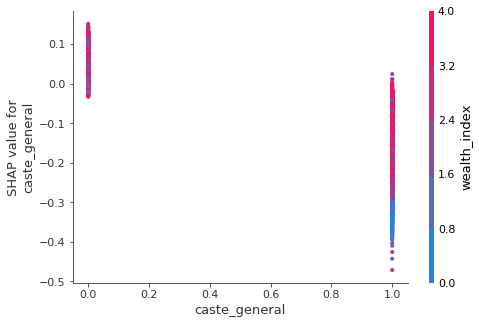


Feature: caste_general, Interaction Feature: no_children_below5


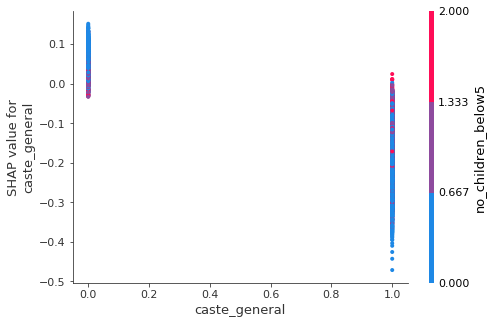


Feature: caste_general, Interaction Feature: total_children


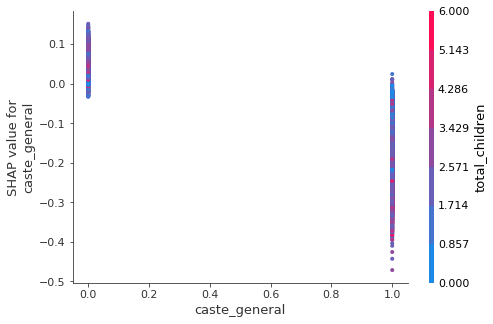


Feature: hh_religion, Interaction Feature: caste_general


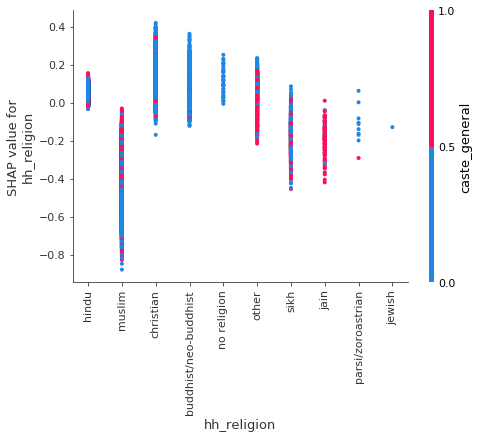


Feature: state, Interaction Feature: caste_general


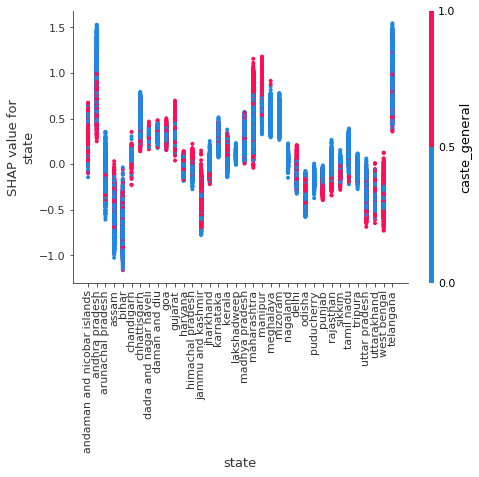

In [40]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
         ('hh_religion', 'caste_general'),
         ('state', 'caste_general')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

---

# Visualizing Bar/Summary plots split by age bins


Age Range: 21 - 25 years
Sample size: 14034

state - 0.2972564236770728
wealth_index - 0.24197248446083183
hh_religion - 0.07546223081358433
women_anemic - 0.01693283988985873
obese_female - 0.04963876737641287
urban - 0.05213919978942414
freq_tv - 0.05666841064025187
age - 0.3944985155422367
years_edu - 0.1847134078136681
hh_members - 0.04973158005826706
no_children_below5 - 0.15084242650963797
total_children - 0.15950038446381645
caste_don't know - 0.00044423499188192447
caste_general - 0.05259056154876783
caste_other backward class - 0.008121893467025567
caste_sc/st - 0.09603196748190816


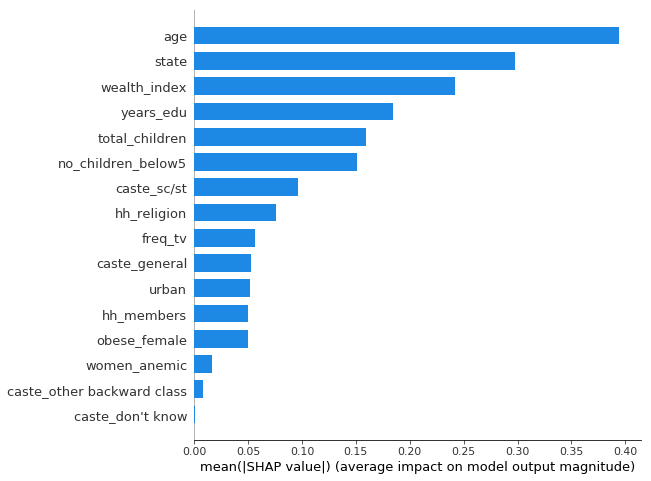

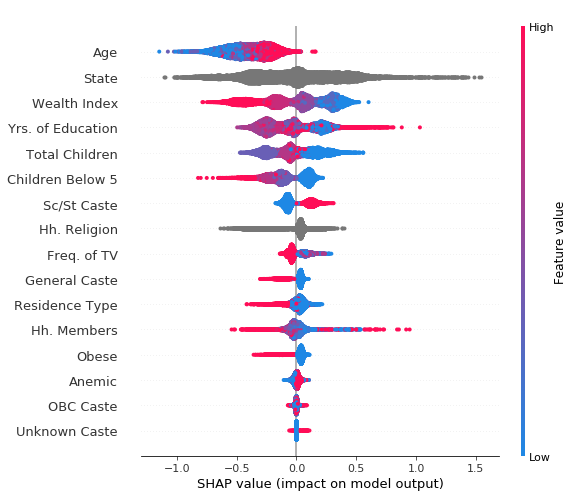


Age Range: 26 - 30 years
Sample size: 13706

state - 0.3254916303073254
wealth_index - 0.2538562647005235
hh_religion - 0.0905988423653642
women_anemic - 0.0159497658784478
obese_female - 0.06983326153720402
urban - 0.07414579022931715
freq_tv - 0.06120287348209388
age - 0.0625872039344211
years_edu - 0.1993618636697258
hh_members - 0.05392166475600239
no_children_below5 - 0.1619778524599905
total_children - 0.08504541857939422
caste_don't know - 0.000490931193848472
caste_general - 0.05860957136014657
caste_other backward class - 0.008370094145807321
caste_sc/st - 0.1021665173000332


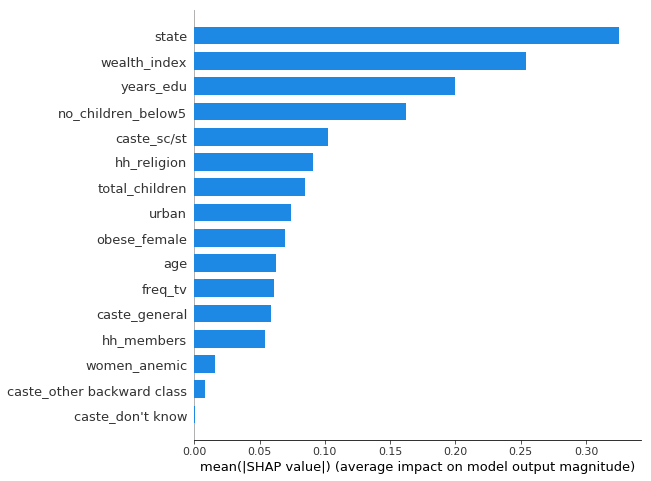

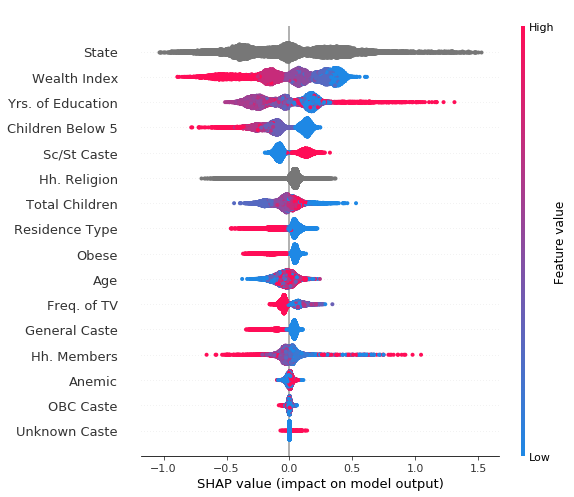


Age Range: 31 - 35 years
Sample size: 12526

state - 0.35156067976322797
wealth_index - 0.2437684612469039
hh_religion - 0.11207056821738032
women_anemic - 0.015835437062925548
obese_female - 0.08272515023291689
urban - 0.06830847416209276
freq_tv - 0.05773609809596271
age - 0.19008049763876156
years_edu - 0.17659553722069787
hh_members - 0.04749409177191126
no_children_below5 - 0.1382038619337119
total_children - 0.0637801602495431
caste_don't know - 0.00027885263313678405
caste_general - 0.06800705456313326
caste_other backward class - 0.009398208093341041
caste_sc/st - 0.1241271231322931


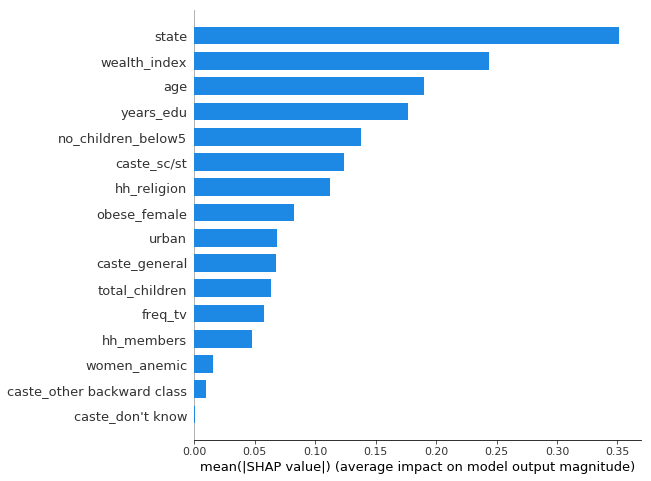

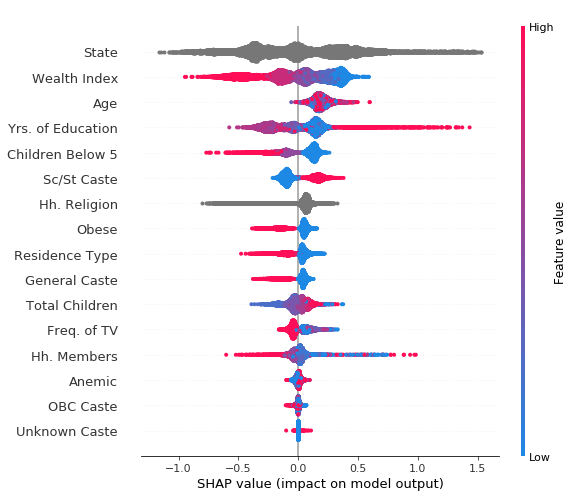


Age Range: 36 - 40 years
Sample size: 11283

state - 0.3531080614785177
wealth_index - 0.2551011930246714
hh_religion - 0.11453727417443697
women_anemic - 0.014215415385937567
obese_female - 0.08080620833866445
urban - 0.061775854307725524
freq_tv - 0.054260713734683164
age - 0.2137766619786097
years_edu - 0.17453706147447903
hh_members - 0.04606484781997994
no_children_below5 - 0.10857563269649795
total_children - 0.06070412743516261
caste_don't know - 0.0002580883446388555
caste_general - 0.07136809825339954
caste_other backward class - 0.010889111209707364
caste_sc/st - 0.1316457152517483


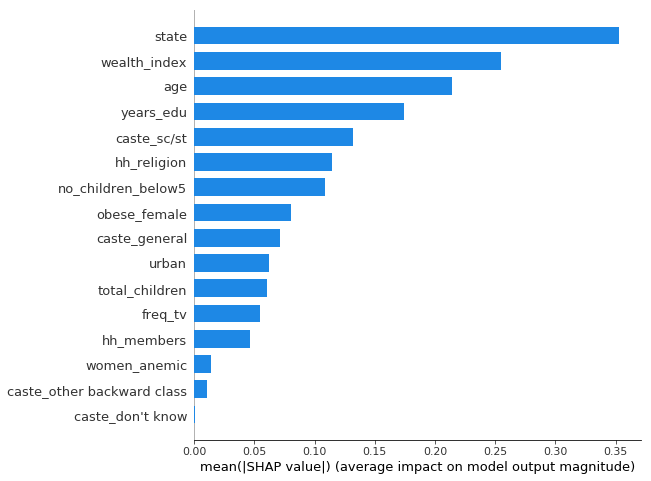

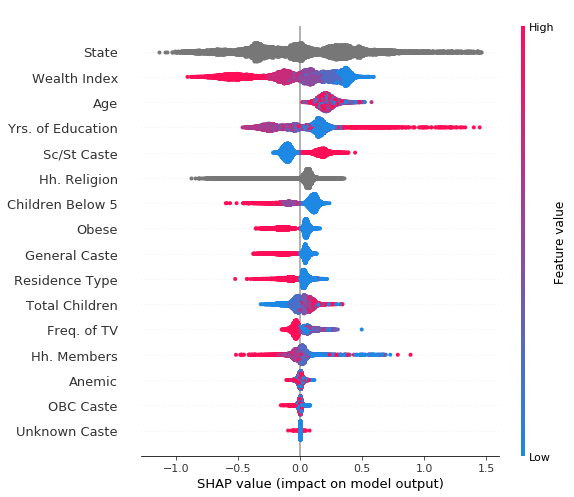


Age Range: 41 - 45 years
Sample size: 10087

state - 0.34187699709057584
wealth_index - 0.2687352215656309
hh_religion - 0.11352790432409295
women_anemic - 0.013746274988944117
obese_female - 0.08435871181910512
urban - 0.05250470259929926
freq_tv - 0.05136092935859466
age - 0.23496455854551804
years_edu - 0.17368968481362915
hh_members - 0.047439067894994275
no_children_below5 - 0.08250724212207443
total_children - 0.05705698161904782
caste_don't know - 0.0002767017603957132
caste_general - 0.08986607856541112
caste_other backward class - 0.011623651458629702
caste_sc/st - 0.1284390446799458


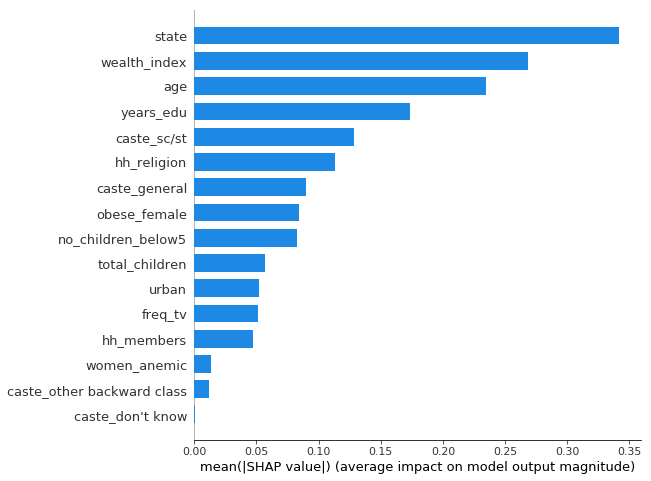

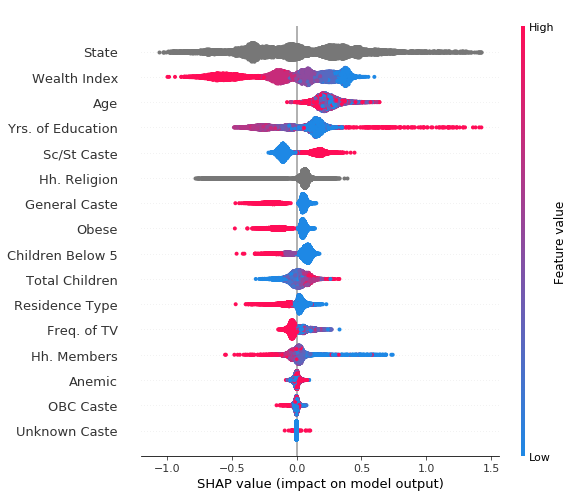


Age Range: 46 - 50 years
Sample size: 6013

state - 0.34458543082747417
wealth_index - 0.2885326747472215
hh_religion - 0.09630622214223115
women_anemic - 0.012781012947304729
obese_female - 0.08765639075371648
urban - 0.056336533172710694
freq_tv - 0.05658346193313582
age - 0.08193257265046906
years_edu - 0.19064263801211714
hh_members - 0.06045825468973749
no_children_below5 - 0.08687897303664893
total_children - 0.059442662406961756
caste_don't know - 0.00027381223443117934
caste_general - 0.07534545243111102
caste_other backward class - 0.010468153665882135
caste_sc/st - 0.12331573422324348


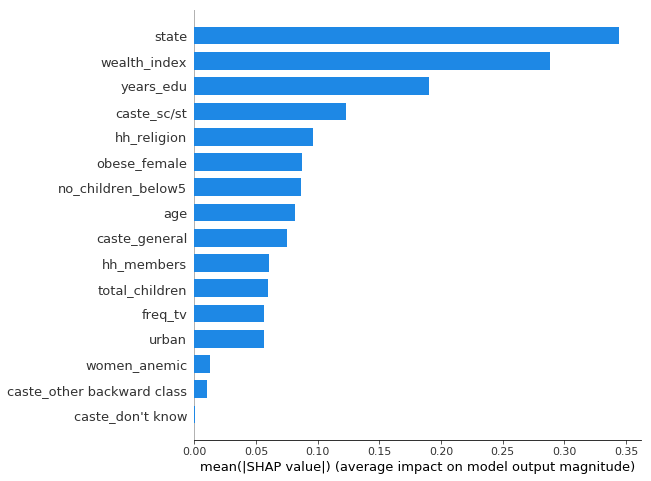

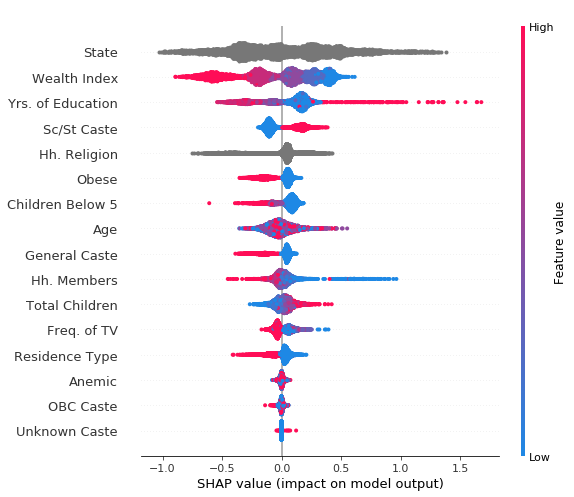

In [41]:
bins = [(21,25), (26,30), (31,35), (36,40), (41,45), (46,50)]

for low, high in bins:
    # Sample dataset by age range
    dataset_sample = dataset[(dataset.age > low) & (dataset.age <= high)]
    dataset_display_sample = dataset_display[(dataset.age > low) & (dataset.age <= high)]
    targets_sample = targets[(dataset.age > low) & (dataset.age <= high)]
    shap_values_sample = shap_values[(dataset.age > low) & (dataset.age <= high)]
    
    print("\nAge Range: {} - {} years".format(low, high))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

# Visualizing Bar/Summary plots split by State


State: andaman and nicobar islands
Sample size: 336

state - 0.254665016301485
wealth_index - 0.27677067622661183
hh_religion - 0.089676534650408
women_anemic - 0.0240505540166919
obese_female - 0.11012408371893463
urban - 0.07833010204718385
freq_tv - 0.035829121079511236
age - 0.28625643589186933
years_edu - 0.2185318215950239
hh_members - 0.03501083783869255
no_children_below5 - 0.11804352016212873
total_children - 0.06662909436117073
caste_don't know - 0.0004804783211302894
caste_general - 0.07761755758902598
caste_other backward class - 0.012838088779137068
caste_sc/st - 0.16737348090694287


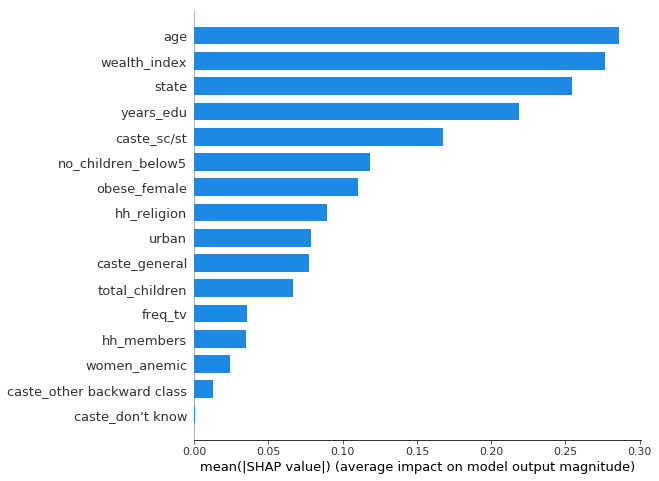

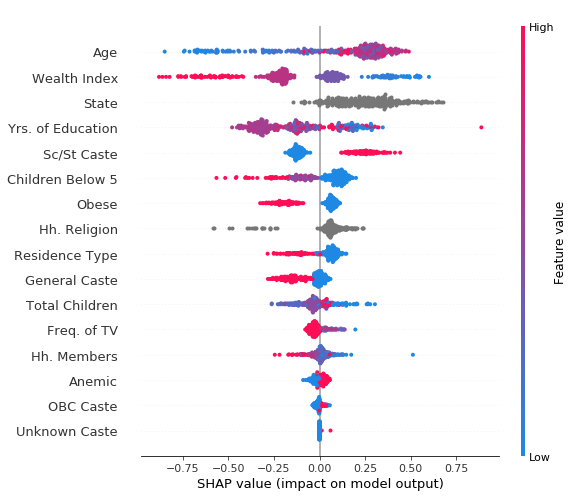


State: andhra pradesh
Sample size: 1239

state - 0.8919153335766106
wealth_index - 0.2806068097531349
hh_religion - 0.10987248044364617
women_anemic - 0.02960256654560089
obese_female - 0.11304341186310263
urban - 0.1346654198995648
freq_tv - 0.028374509784282735
age - 0.3029009399742421
years_edu - 0.19657884020852687
hh_members - 0.05181688338938117
no_children_below5 - 0.12069192944999657
total_children - 0.060580705015443805
caste_don't know - 0.0006787380384570144
caste_general - 0.11422619137339925
caste_other backward class - 0.011873662194526399
caste_sc/st - 0.13066907195305974


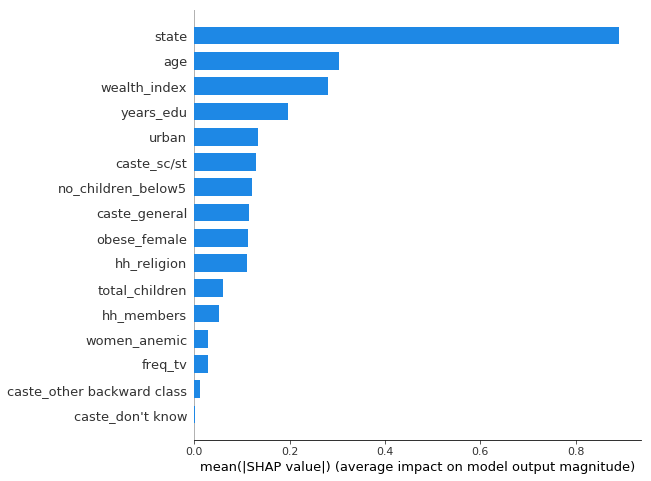

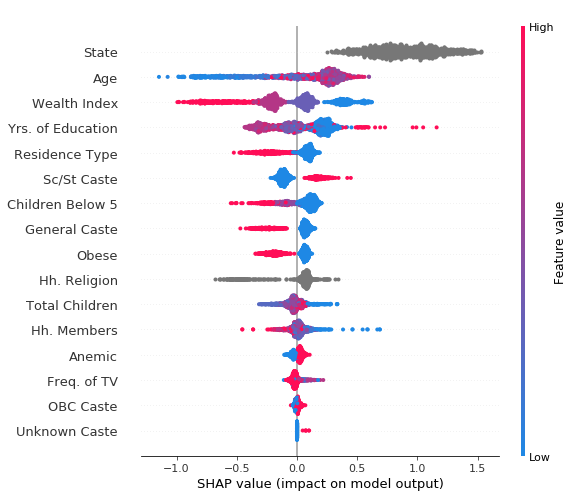


State: arunachal pradesh
Sample size: 1662

state - 0.1547288543276053
wealth_index - 0.13425580760674571
hh_religion - 0.12374703901999581
women_anemic - 0.023949793442503385
obese_female - 0.07758375997572953
urban - 0.08141595453339333
freq_tv - 0.08090519651391834
age - 0.21144514215192564
years_edu - 0.181327913366448
hh_members - 0.05524605768965706
no_children_below5 - 0.06632990873297309
total_children - 0.07077705173488119
caste_don't know - 0.0004986959579437947
caste_general - 0.054725560462795766
caste_other backward class - 0.004313347186929389
caste_sc/st - 0.08682576963301855


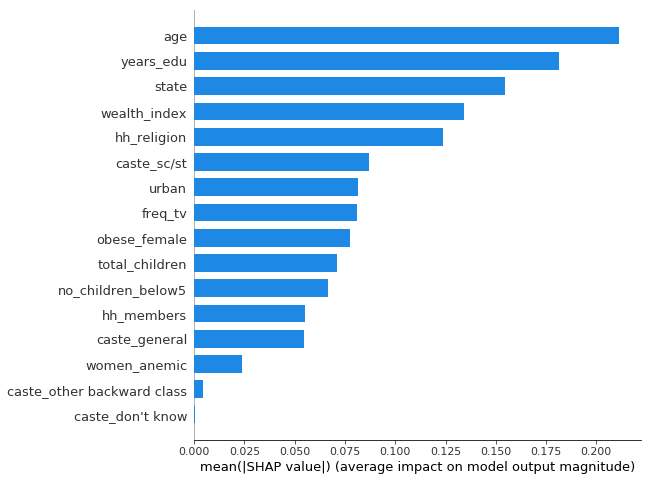

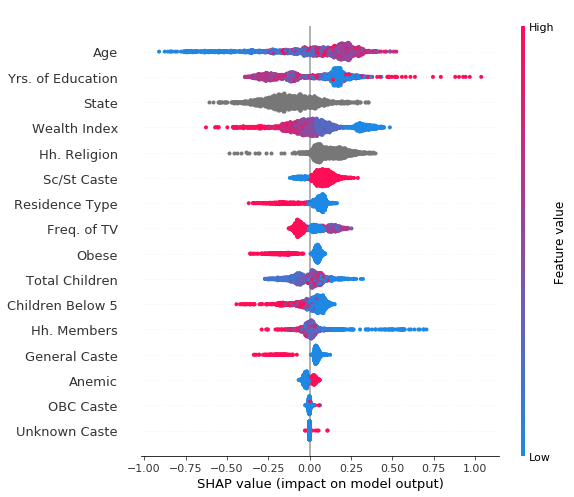


State: assam
Sample size: 2858

state - 0.558842045027065
wealth_index - 0.1466569779925637
hh_religion - 0.06761413591455542
women_anemic - 0.012076385651266383
obese_female - 0.0705124662069736
urban - 0.0312529814574393
freq_tv - 0.07565607073383865
age - 0.1801772926456268
years_edu - 0.2091749840235262
hh_members - 0.046010619973854965
no_children_below5 - 0.11460196393831631
total_children - 0.09050799070741235
caste_don't know - 0.0006328938898979507
caste_general - 0.05450258738326848
caste_other backward class - 0.006016397958119344
caste_sc/st - 0.06843428907561919


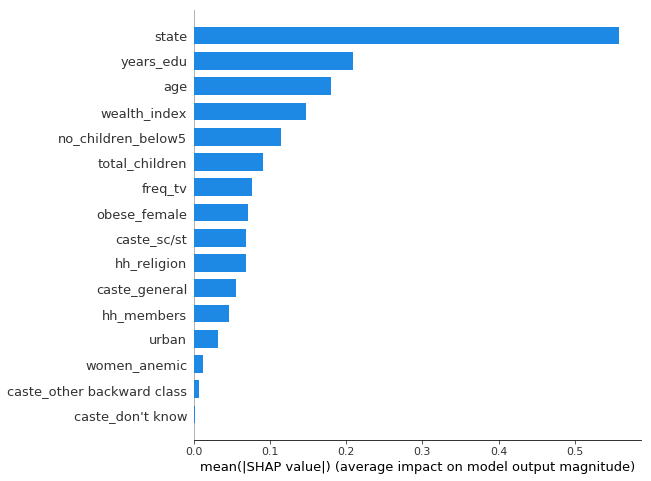

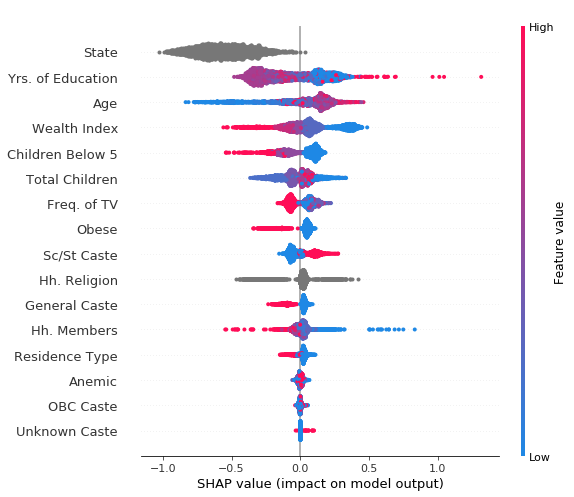


State: bihar
Sample size: 4860

state - 0.6780032612257147
wealth_index - 0.19834587598139478
hh_religion - 0.05643056204615869
women_anemic - 0.020390565012053677
obese_female - 0.06745358703064579
urban - 0.0363226531464857
freq_tv - 0.06952761975011855
age - 0.190344011188818
years_edu - 0.1464857311498727
hh_members - 0.06068356252775789
no_children_below5 - 0.14257829196460767
total_children - 0.08333400382116224
caste_don't know - 0.00029608061048036125
caste_general - 0.06731864844676985
caste_other backward class - 0.009549728053867881
caste_sc/st - 0.14739341797130678


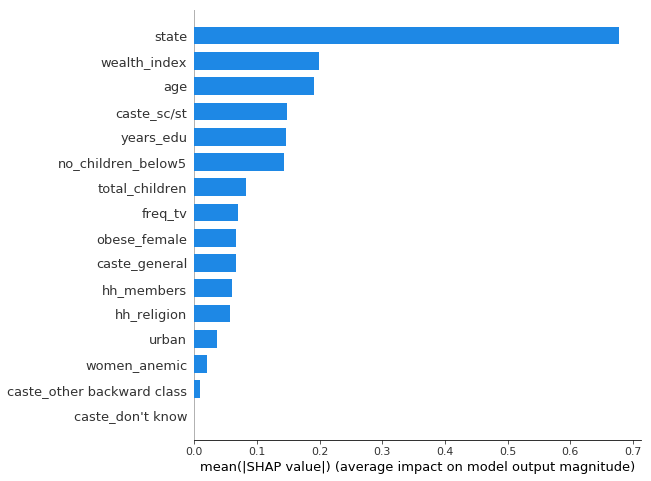

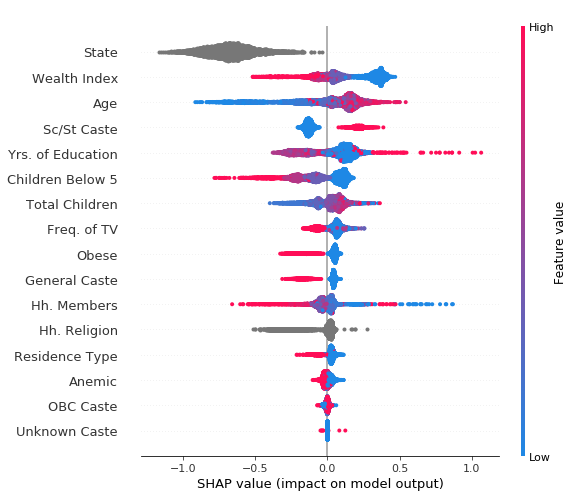


State: chandigarh
Sample size: 87

state - 0.11326867261053192
wealth_index - 0.3541067020937406
hh_religion - 0.07390780859627842
women_anemic - 0.028077856539744078
obese_female - 0.04757089092627399
urban - 0.08255910598503235
freq_tv - 0.06302538644314713
age - 0.249939188596497
years_edu - 0.2098907524800015
hh_members - 0.053996171610836474
no_children_below5 - 0.07696798625664561
total_children - 0.10420342102067182
caste_don't know - 0.0002702878975110729
caste_general - 0.08624595954475371
caste_other backward class - 0.01331054265903464
caste_sc/st - 0.11838523659020206


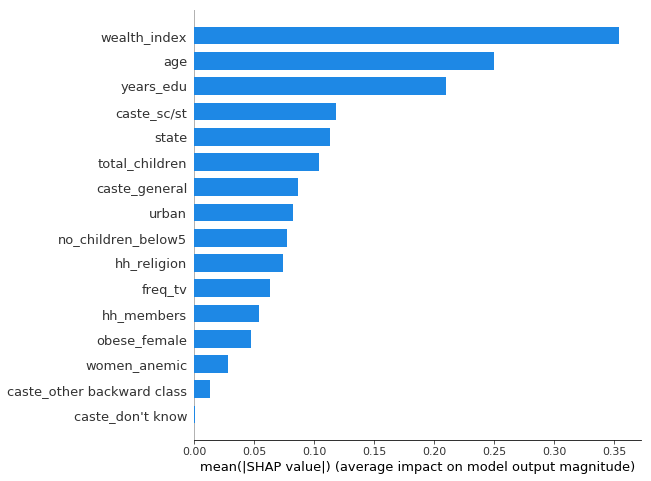

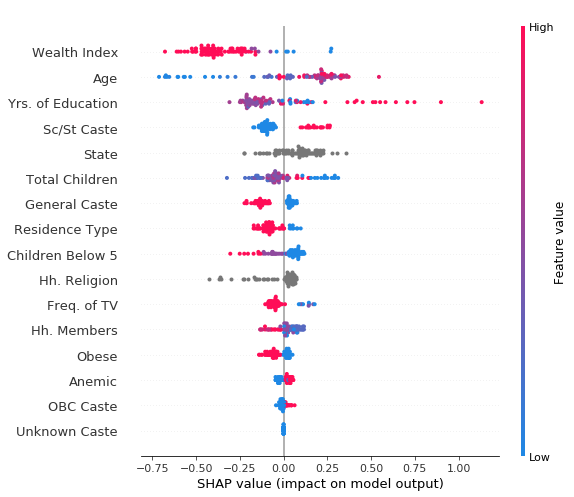


State: chhattisgarh
Sample size: 2836

state - 0.5107177287581478
wealth_index - 0.30645362779556834
hh_religion - 0.07311074181916638
women_anemic - 0.02795380023153078
obese_female - 0.06924399947341017
urban - 0.06795179249878097
freq_tv - 0.06648757434477502
age - 0.2363577276885215
years_edu - 0.16658921727647777
hh_members - 0.034641474579796216
no_children_below5 - 0.1422198230948125
total_children - 0.07828927225852328
caste_don't know - 0.0002481520180594809
caste_general - 0.05220933172417978
caste_other backward class - 0.008378411585461272
caste_sc/st - 0.08933417159282231


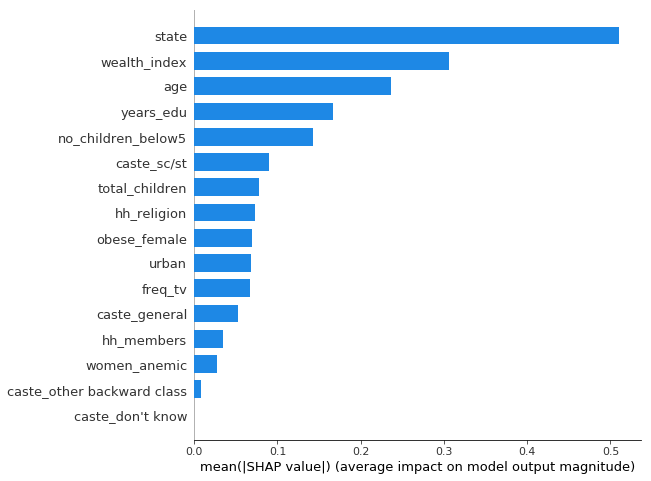

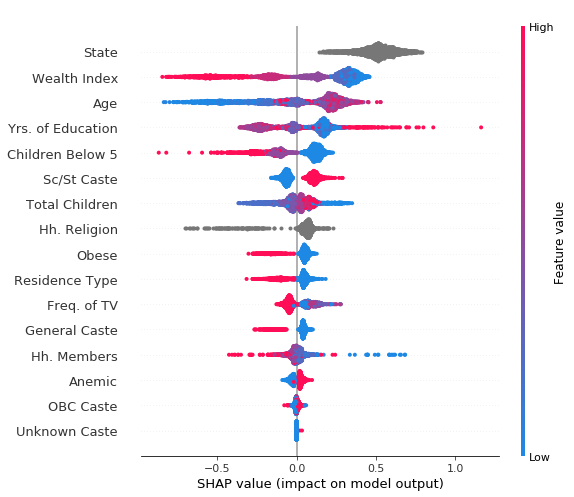


State: dadra and nagar haveli
Sample size: 118

state - 0.33070887620192263
wealth_index - 0.2788629200549233
hh_religion - 0.05905912955639296
women_anemic - 0.019168806576703227
obese_female - 0.06483134751164553
urban - 0.053691242027622384
freq_tv - 0.0702989391006548
age - 0.21036573631139263
years_edu - 0.1600524954735867
hh_members - 0.04250267479368272
no_children_below5 - 0.14903411021851992
total_children - 0.08345492457652488
caste_don't know - 0.0008346553065259151
caste_general - 0.05872124094574452
caste_other backward class - 0.00564814662280999
caste_sc/st - 0.1200408035599177


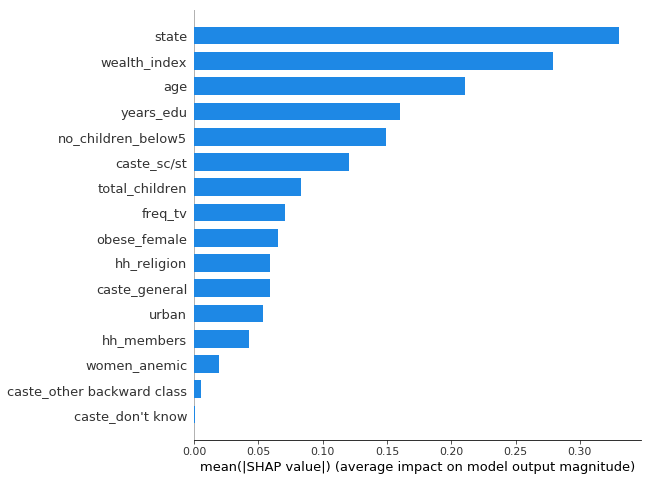

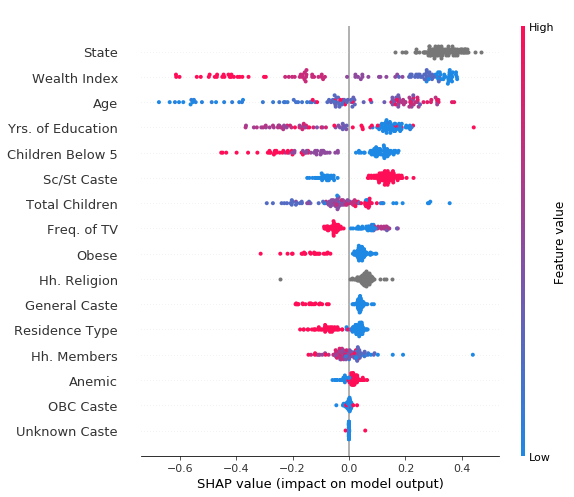


State: daman and diu
Sample size: 252

state - 0.3316728462933511
wealth_index - 0.2938830961309183
hh_religion - 0.08674677637563016
women_anemic - 0.022751415384793944
obese_female - 0.08101559033141109
urban - 0.06358783457425471
freq_tv - 0.053128769019867586
age - 0.21889175159212024
years_edu - 0.1652888338072035
hh_members - 0.05610212777885117
no_children_below5 - 0.12692308569548694
total_children - 0.10736874452482008
caste_don't know - 0.0026988695630392797
caste_general - 0.05045813818734181
caste_other backward class - 0.007678390537665864
caste_sc/st - 0.08703736022244435


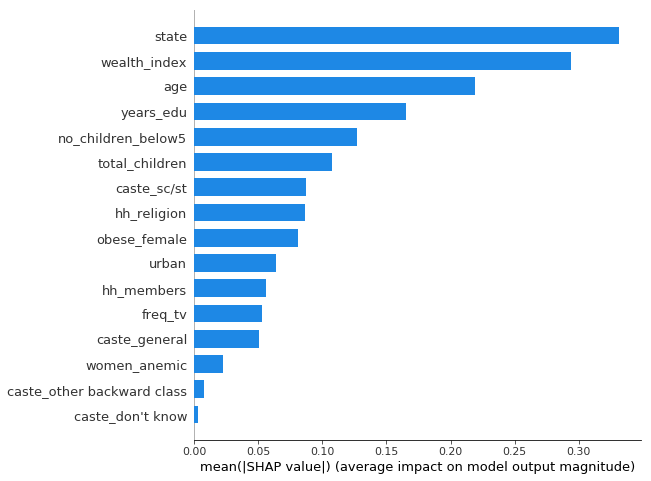

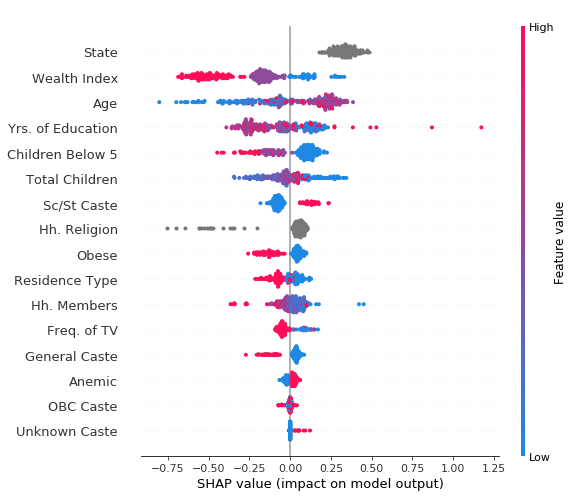


State: goa
Sample size: 567

state - 0.3328280755133247
wealth_index - 0.31008218124880543
hh_religion - 0.07452322318564615
women_anemic - 0.01771405118394429
obese_female - 0.0943508623413921
urban - 0.05885445483685143
freq_tv - 0.06089859952623897
age - 0.21661452978613663
years_edu - 0.1830058814800378
hh_members - 0.05181223152512565
no_children_below5 - 0.11084786719724714
total_children - 0.09821383167563959
caste_don't know - 0.0002841497325032579
caste_general - 0.08761971432462586
caste_other backward class - 0.007944184254867337
caste_sc/st - 0.09292056969346767


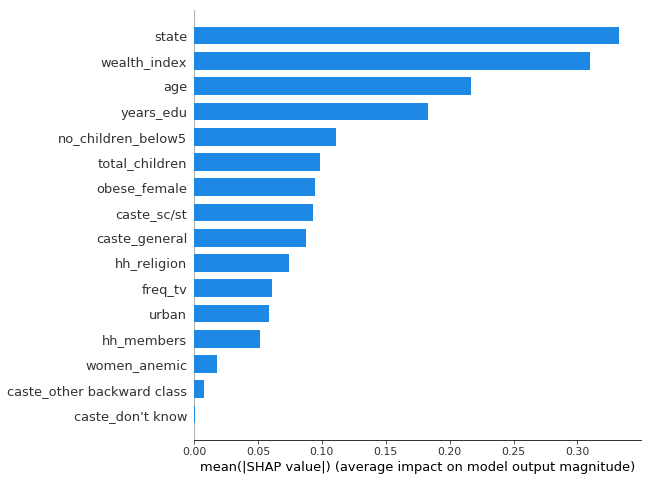

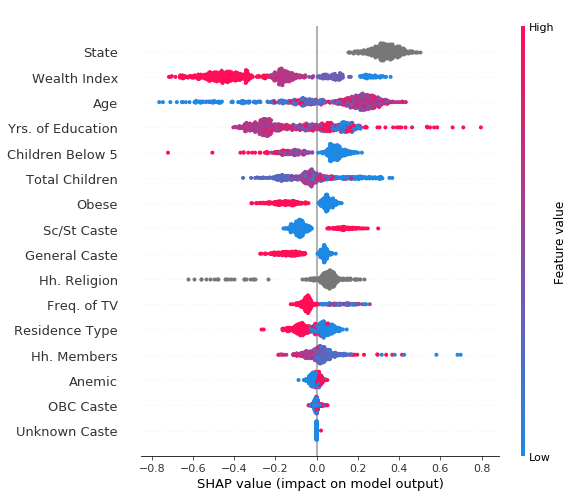


State: gujarat
Sample size: 4197

state - 0.3697932319507676
wealth_index - 0.2356791048714404
hh_religion - 0.09541528982564042
women_anemic - 0.01854337702733705
obese_female - 0.06521574676291142
urban - 0.05059802968728547
freq_tv - 0.06304810437787561
age - 0.22560862628535971
years_edu - 0.14441062838873328
hh_members - 0.04588710024486946
no_children_below5 - 0.13777362912026925
total_children - 0.08086490988814049
caste_don't know - 0.0008120560392552486
caste_general - 0.062221962900996124
caste_other backward class - 0.006184986567621223
caste_sc/st - 0.10123026329042066


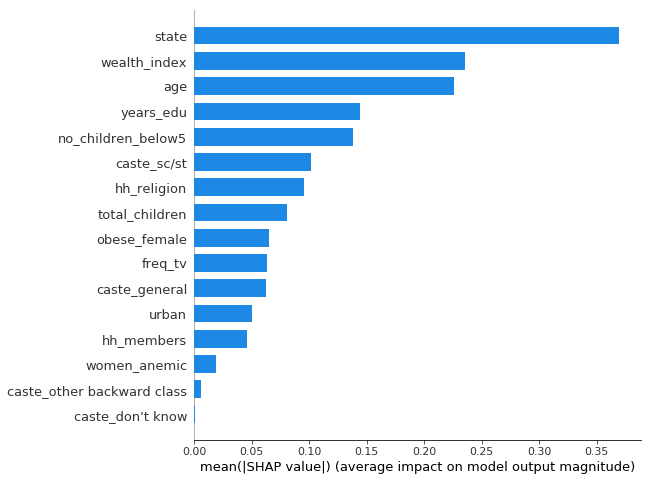

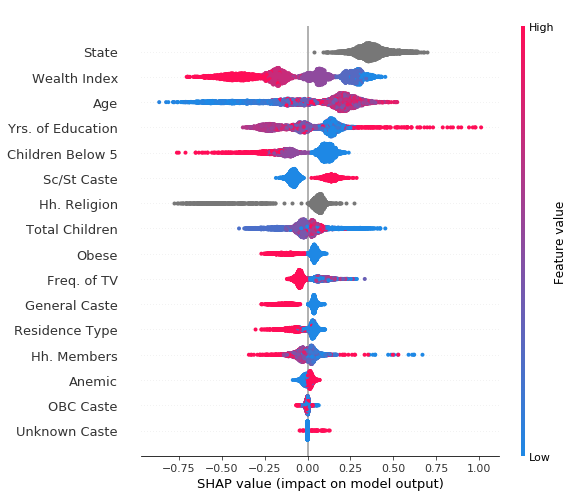


State: haryana
Sample size: 2415

state - 0.03860944653487521
wealth_index - 0.32076510450786755
hh_religion - 0.07327110003621616
women_anemic - 0.011585546064924705
obese_female - 0.05765430371175871
urban - 0.05727145811899313
freq_tv - 0.05008095807752667
age - 0.2256930517695551
years_edu - 0.17389143416005154
hh_members - 0.04050413298068779
no_children_below5 - 0.10308330739741953
total_children - 0.09036242586574311
caste_don't know - 0.000294543998232975
caste_general - 0.054436172676319956
caste_other backward class - 0.005043766373016398
caste_sc/st - 0.10321952727960748


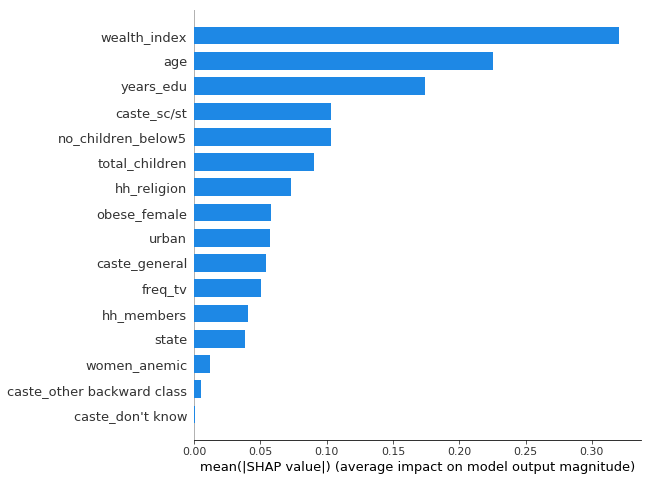

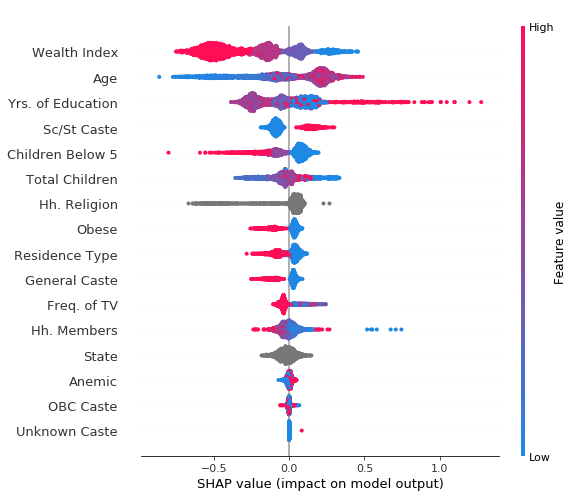


State: himachal pradesh
Sample size: 2193

state - 0.045500134081505085
wealth_index - 0.20459302757807252
hh_religion - 0.0598196552519876
women_anemic - 0.014911949868887412
obese_female - 0.06513687909633127
urban - 0.04085961905188298
freq_tv - 0.04395077821090707
age - 0.22277800001017445
years_edu - 0.18676445372179046
hh_members - 0.03909060559678554
no_children_below5 - 0.10417680556308923
total_children - 0.07591825251288044
caste_don't know - 0.0004958895844081214
caste_general - 0.08303168965837969
caste_other backward class - 0.005695466435882408
caste_sc/st - 0.11362093413366851


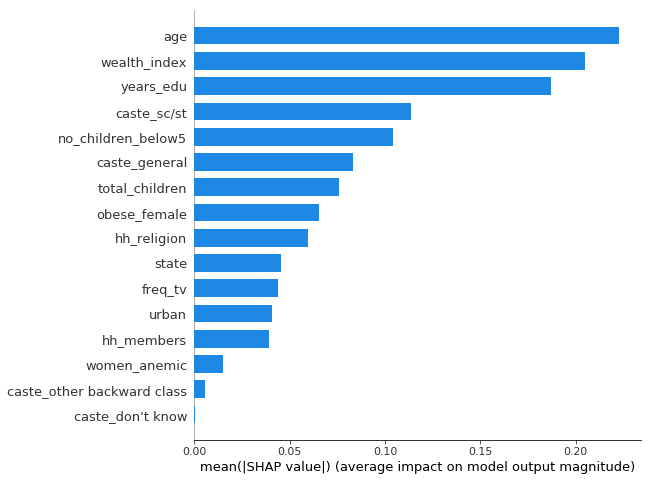

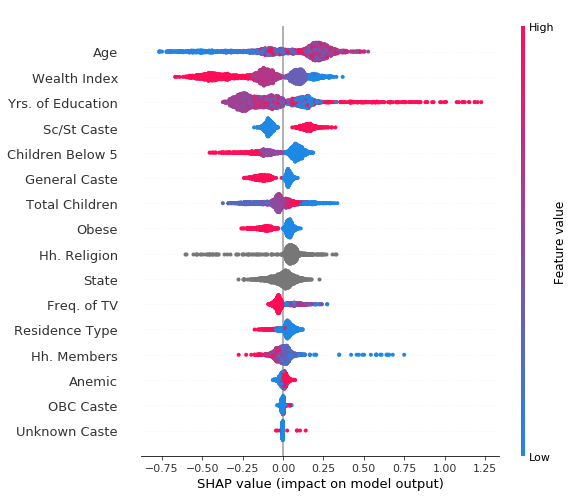


State: jammu and kashmir
Sample size: 2889

state - 0.38574558466373116
wealth_index - 0.18082153135962045
hh_religion - 0.22590981156245574
women_anemic - 0.011143607669507359
obese_female - 0.06620796839904418
urban - 0.03400762516451174
freq_tv - 0.038087718120538384
age - 0.17424523616844578
years_edu - 0.136369857003904
hh_members - 0.04079437772341405
no_children_below5 - 0.0953992511804764
total_children - 0.07598444783335753
caste_don't know - 0.00044366094418704253
caste_general - 0.07517225114700782
caste_other backward class - 0.005765755351602782
caste_sc/st - 0.11270195944992481


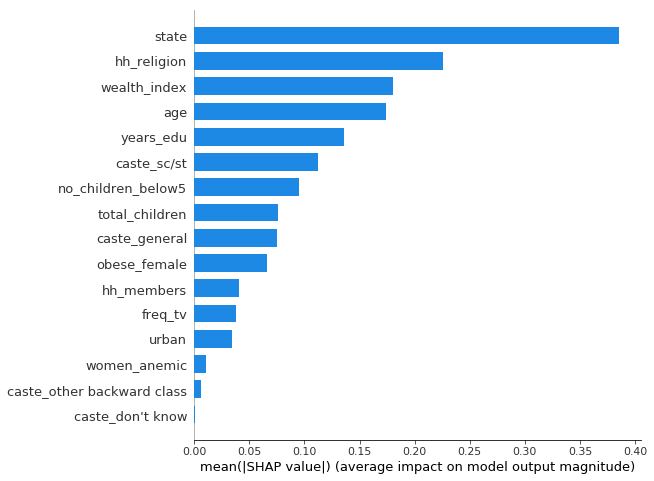

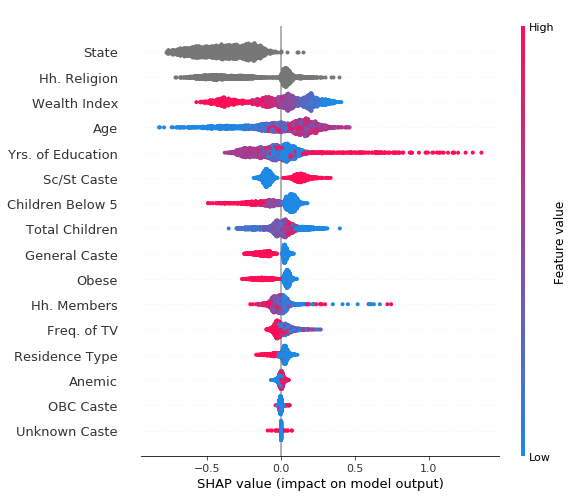


State: jharkhand
Sample size: 3171

state - 0.05292145706089348
wealth_index - 0.3110044377013147
hh_religion - 0.09987824210390851
women_anemic - 0.009635692008112203
obese_female - 0.05105296722546849
urban - 0.05398431828089508
freq_tv - 0.05268531266202321
age - 0.19525278010914945
years_edu - 0.16607279482897064
hh_members - 0.039539481752227254
no_children_below5 - 0.13666092632369323
total_children - 0.07458463145188414
caste_don't know - 0.0002883904587458037
caste_general - 0.06261053338855266
caste_other backward class - 0.004734678083364141
caste_sc/st - 0.13744318223943353


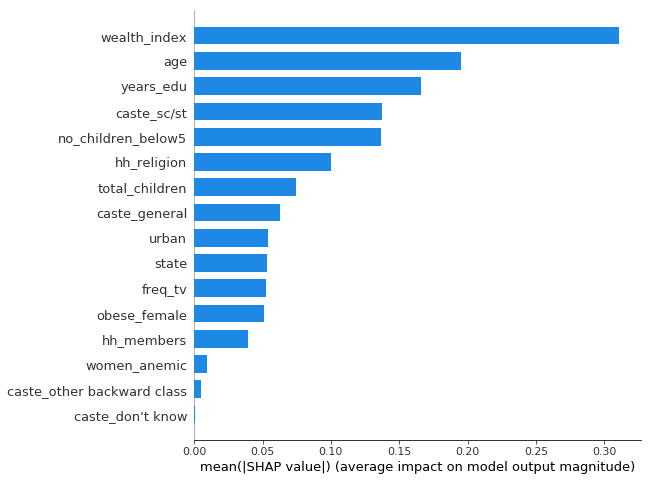

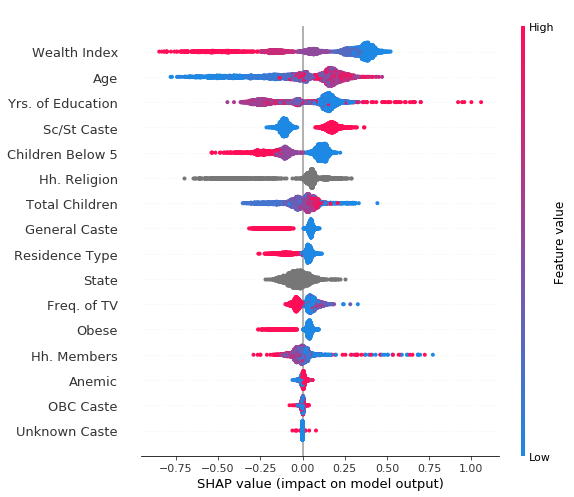


State: karnataka
Sample size: 2920

state - 0.26713102524585164
wealth_index - 0.2227674530895616
hh_religion - 0.09947898003168883
women_anemic - 0.014732246192463367
obese_female - 0.08037979450591975
urban - 0.035171545214582295
freq_tv - 0.05069323849360154
age - 0.23069797163669206
years_edu - 0.16517107767068007
hh_members - 0.04357051618338676
no_children_below5 - 0.13861599905931096
total_children - 0.07236822160408249
caste_don't know - 0.0004537092225947885
caste_general - 0.045999689414513774
caste_other backward class - 0.006733132682219814
caste_sc/st - 0.1068488314401486


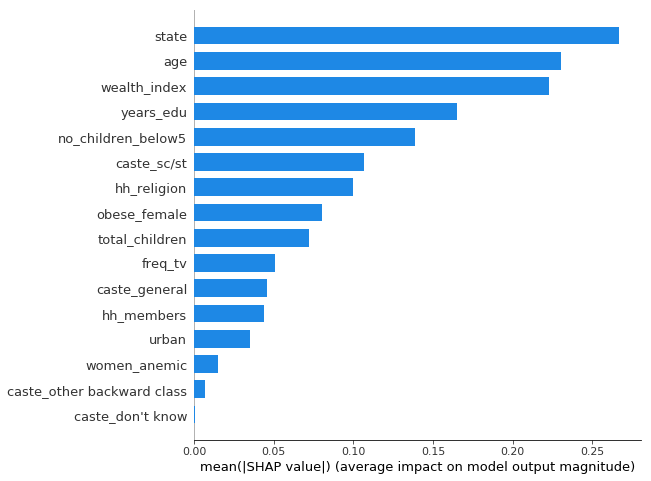

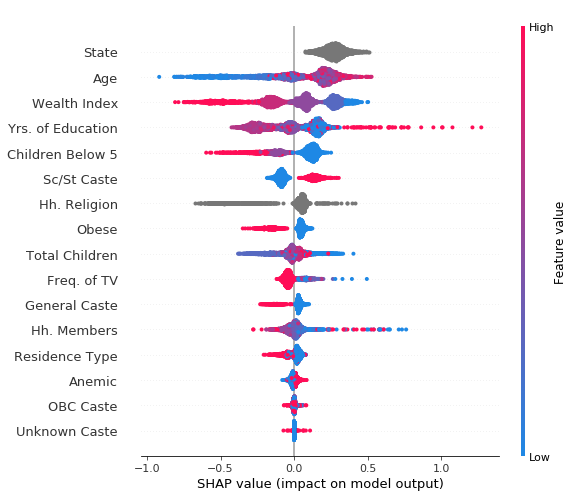


State: kerala
Sample size: 1761

state - 0.12796853905046995
wealth_index - 0.291622269650007
hh_religion - 0.19294915274984564
women_anemic - 0.01937606058968815
obese_female - 0.08789392203234737
urban - 0.04400485206773526
freq_tv - 0.054406311368865604
age - 0.2314246363407121
years_edu - 0.26100334931187574
hh_members - 0.04444878361363085
no_children_below5 - 0.11527021800455646
total_children - 0.08427484402619603
caste_don't know - 0.00032516100113756777
caste_general - 0.06221158526245618
caste_other backward class - 0.009163010271431734
caste_sc/st - 0.11558958654315617


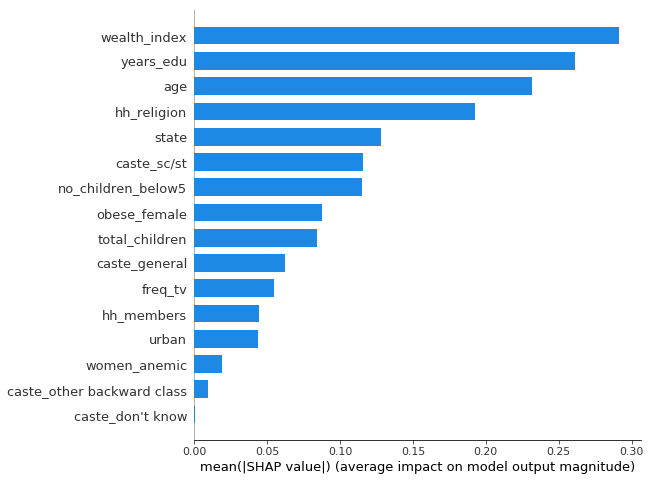

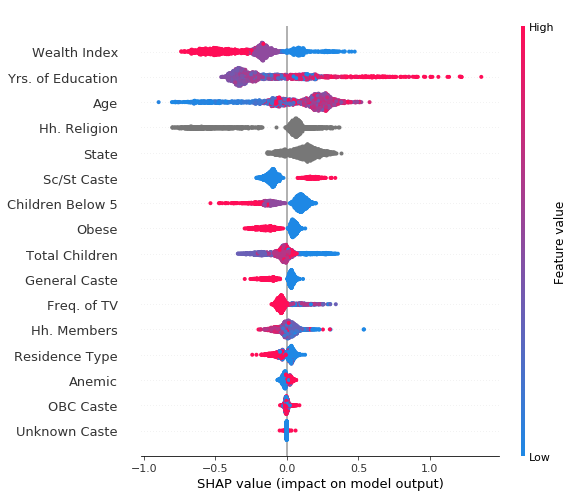


State: lakshadweep
Sample size: 165

state - 0.10587495677822455
wealth_index - 0.3598863257391388
hh_religion - 0.47406690272309726
women_anemic - 0.023831059125811984
obese_female - 0.12483038673493062
urban - 0.05174633287974279
freq_tv - 0.07349473303697834
age - 0.22906847024426186
years_edu - 0.2225399221629286
hh_members - 0.05242301494578494
no_children_below5 - 0.11726993550155772
total_children - 0.11044498550551475
caste_don't know - 0.00011355930045895141
caste_general - 0.031606566060581986
caste_other backward class - 0.00892652127018027
caste_sc/st - 0.19974884849124844


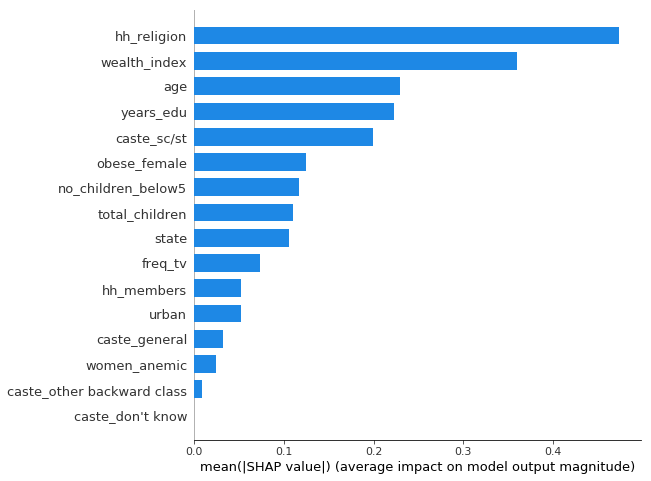

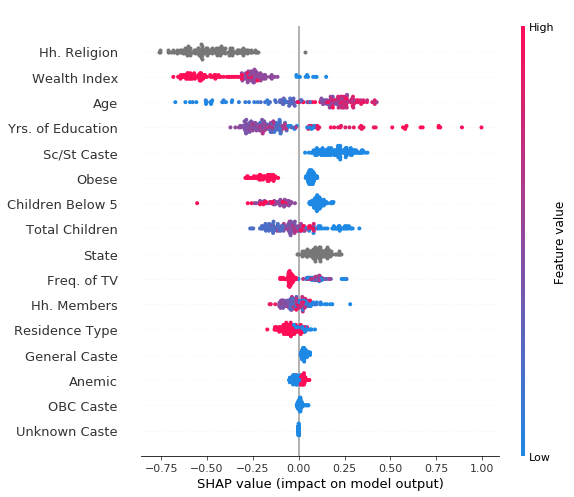


State: madhya pradesh
Sample size: 6829

state - 0.3369252833609966
wealth_index - 0.32080712470286266
hh_religion - 0.08762010102814191
women_anemic - 0.0112846876302026
obese_female - 0.07064509898261644
urban - 0.08408682263004032
freq_tv - 0.05981714739552466
age - 0.21941107887378378
years_edu - 0.18819625924532696
hh_members - 0.04471454681969305
no_children_below5 - 0.13139501608828882
total_children - 0.07694932944576517
caste_don't know - 0.00023113250203988581
caste_general - 0.056041209402187465
caste_other backward class - 0.014566057270976849
caste_sc/st - 0.1299536655114422


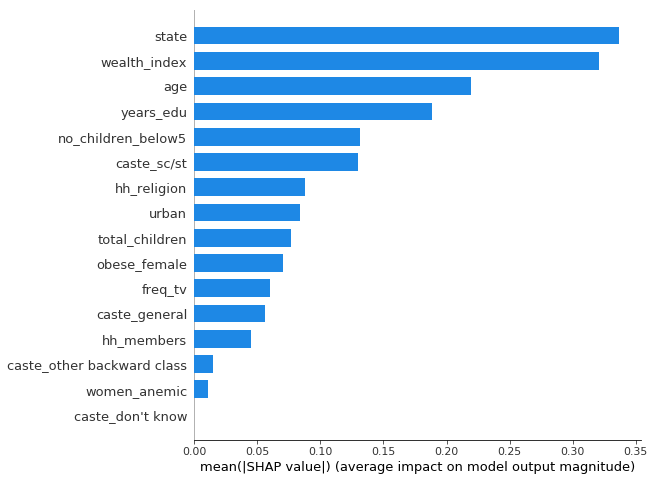

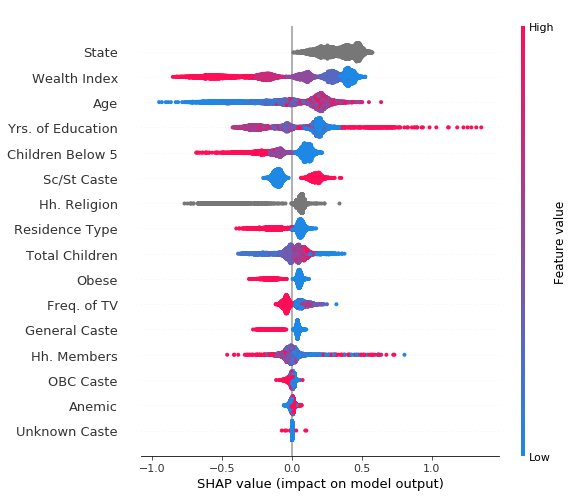


State: maharashtra
Sample size: 3368

state - 0.5337981614405404
wealth_index - 0.2950730387783939
hh_religion - 0.12425293580570365
women_anemic - 0.019276189981007212
obese_female - 0.10871185903887307
urban - 0.12382738919210673
freq_tv - 0.06899860191803096
age - 0.2501395460045351
years_edu - 0.19086562695938314
hh_members - 0.06801379431911483
no_children_below5 - 0.13397867007170192
total_children - 0.07529583274901132
caste_don't know - 0.00031357247877853795
caste_general - 0.04740509925757716
caste_other backward class - 0.015382163433210121
caste_sc/st - 0.08852796720934919


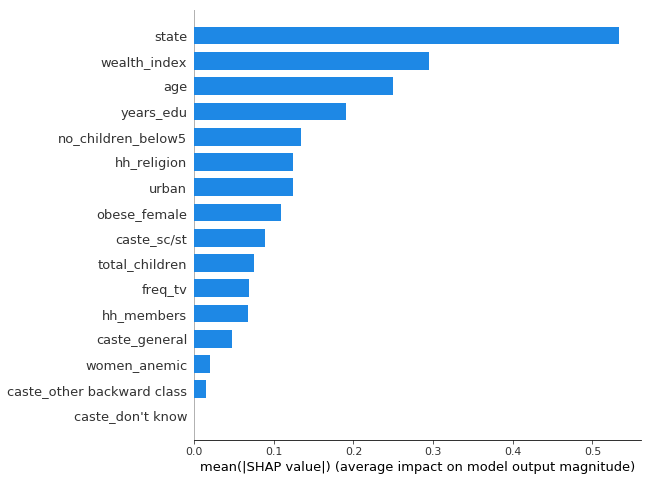

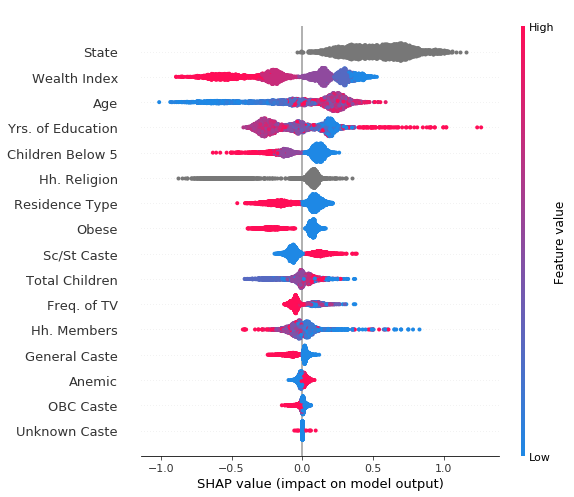


State: manipur
Sample size: 1417

state - 0.6834350382706382
wealth_index - 0.22499139399329718
hh_religion - 0.11964962845707586
women_anemic - 0.017370401316812945
obese_female - 0.11402935821764584
urban - 0.09189194922401352
freq_tv - 0.08194770076570947
age - 0.23792903012545963
years_edu - 0.195723591803835
hh_members - 0.05060951267278632
no_children_below5 - 0.14822377111046595
total_children - 0.09049259207449353
caste_don't know - 0.0006015932021480819
caste_general - 0.0465719716924384
caste_other backward class - 0.018302753153345872
caste_sc/st - 0.09117263385634998


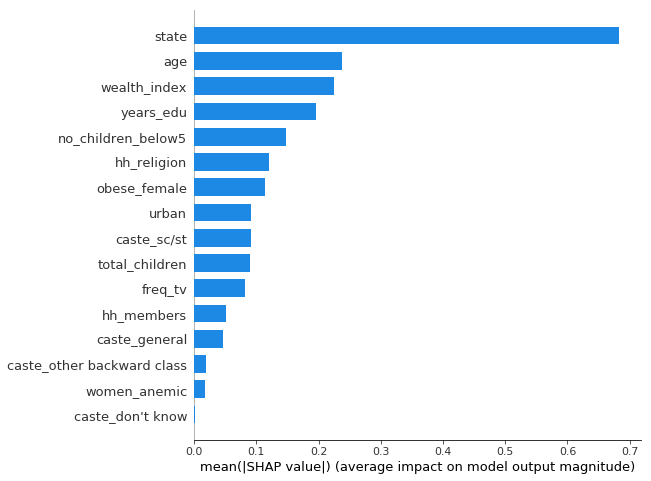

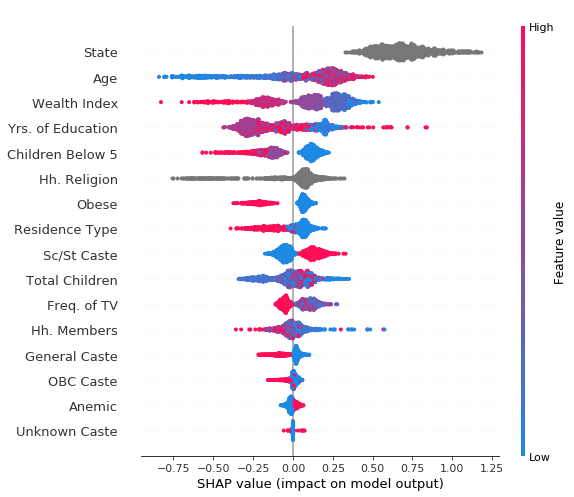


State: meghalaya
Sample size: 913

state - 0.5489122336501859
wealth_index - 0.2151742575106547
hh_religion - 0.144526410121471
women_anemic - 0.019747534868607117
obese_female - 0.08460672240672457
urban - 0.0656857097911094
freq_tv - 0.0875045140391927
age - 0.2714211936939923
years_edu - 0.18641229570149265
hh_members - 0.03985005857654459
no_children_below5 - 0.15494909092782913
total_children - 0.08950908624489574
caste_don't know - 0.00017380543576423795
caste_general - 0.028110818546493846
caste_other backward class - 0.015054630077237134
caste_sc/st - 0.14887269332822065


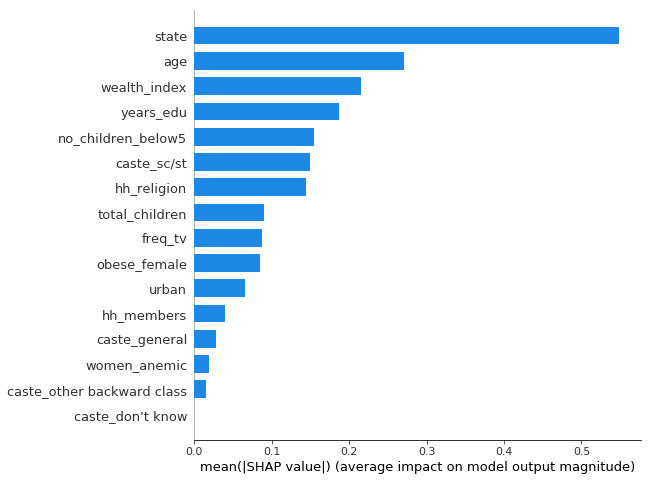

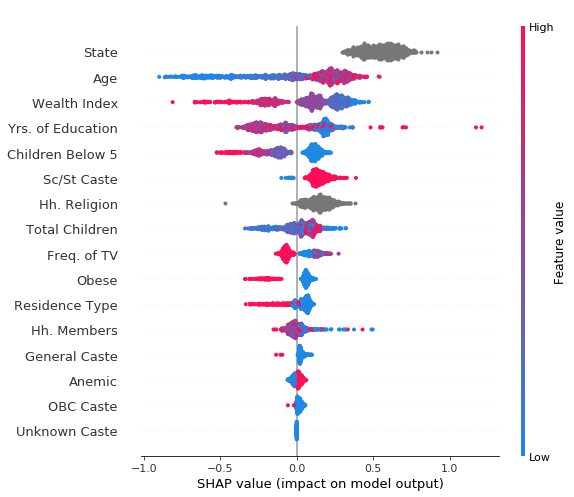


State: mizoram
Sample size: 1407

state - 0.481166536752344
wealth_index - 0.27157291238367726
hh_religion - 0.1745563933093374
women_anemic - 0.02207754847472828
obese_female - 0.09426359397650387
urban - 0.07368873038478994
freq_tv - 0.09999586155076225
age - 0.25977839586966783
years_edu - 0.1776137324041874
hh_members - 0.049672291123849244
no_children_below5 - 0.1365416484594495
total_children - 0.09052443683766047
caste_don't know - 0.00039825235636443024
caste_general - 0.03125753698378727
caste_other backward class - 0.012270595209018584
caste_sc/st - 0.16174595489290966


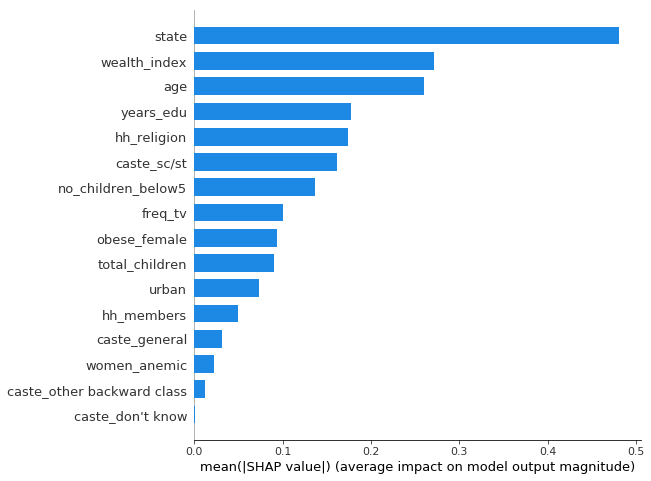

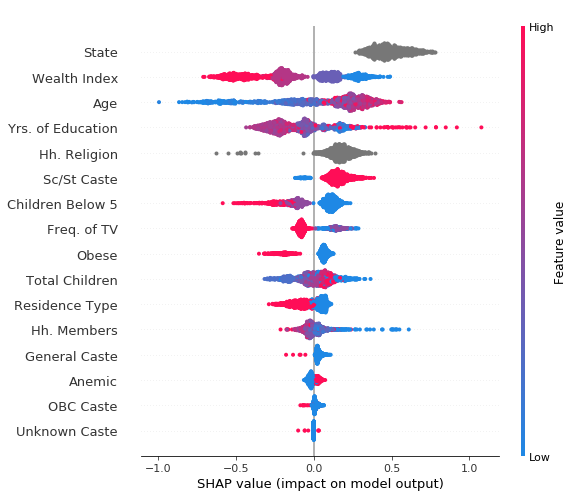


State: nagaland
Sample size: 1157

state - 0.05831013724777317
wealth_index - 0.17440169995780166
hh_religion - 0.14687710810647078
women_anemic - 0.017230181816312654
obese_female - 0.08589508377043624
urban - 0.053083311024947274
freq_tv - 0.08548641932179861
age - 0.2040149532144217
years_edu - 0.20371284205256424
hh_members - 0.03815343686175234
no_children_below5 - 0.13207336014603654
total_children - 0.08080650412587753
caste_don't know - 0.00023573539949703053
caste_general - 0.032498025756277825
caste_other backward class - 0.008822982661072738
caste_sc/st - 0.1599251117783058


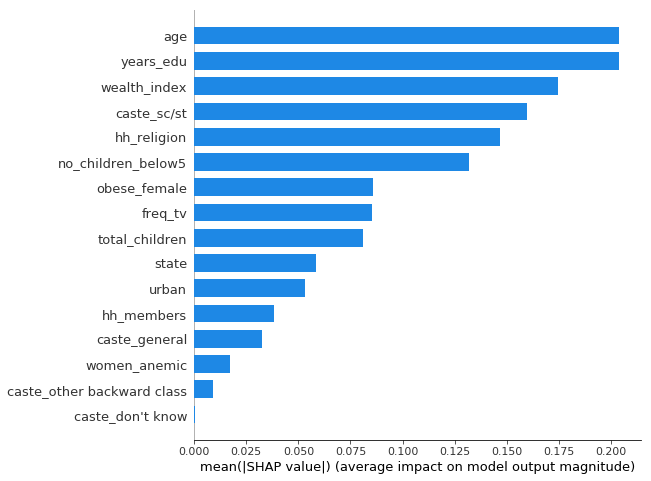

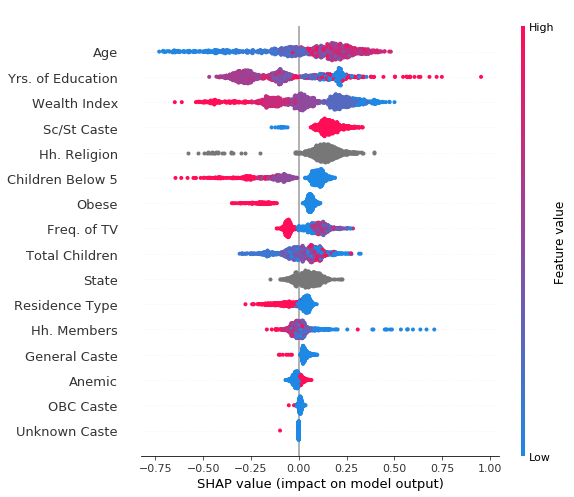


State: delhi
Sample size: 485

state - 0.11522065817160901
wealth_index - 0.3891878075976209
hh_religion - 0.12832810684334114
women_anemic - 0.020798404676358323
obese_female - 0.10478780701415873
urban - 0.09902604391363319
freq_tv - 0.04924001316270694
age - 0.1886641405055134
years_edu - 0.2270944356815201
hh_members - 0.06368977632238496
no_children_below5 - 0.11712169216215274
total_children - 0.1195886619665818
caste_don't know - 0.0007149397230571071
caste_general - 0.051993570742868325
caste_other backward class - 0.009661135290717677
caste_sc/st - 0.10488164708710772


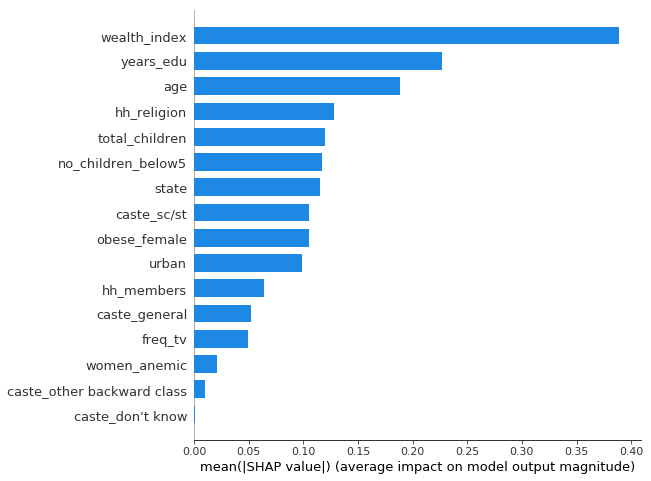

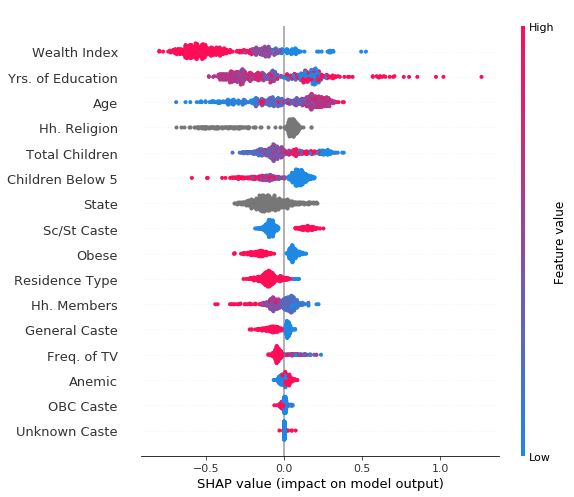


State: odisha
Sample size: 3864

state - 0.3096996342582037
wealth_index - 0.2444659671505959
hh_religion - 0.04966457070456177
women_anemic - 0.012399352593893328
obese_female - 0.06264916765813859
urban - 0.040808687652350975
freq_tv - 0.05974359184460191
age - 0.17806793751698638
years_edu - 0.21693845726165206
hh_members - 0.03985204513432227
no_children_below5 - 0.11087236259296843
total_children - 0.08431755671552217
caste_don't know - 0.00024915110675047936
caste_general - 0.06607893963558496
caste_other backward class - 0.010684534789779902
caste_sc/st - 0.14834476591082885


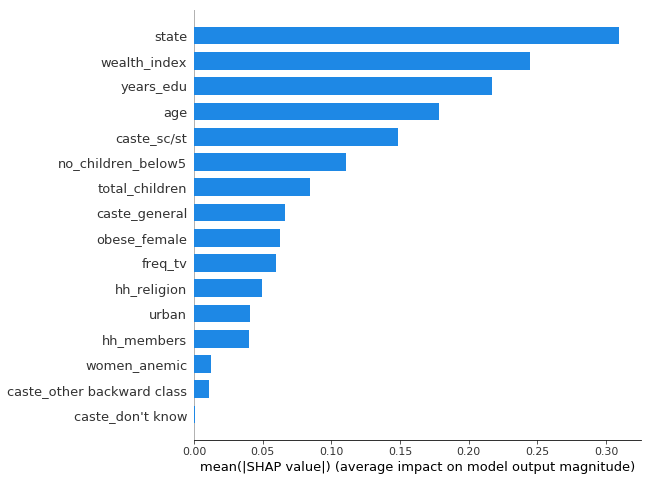

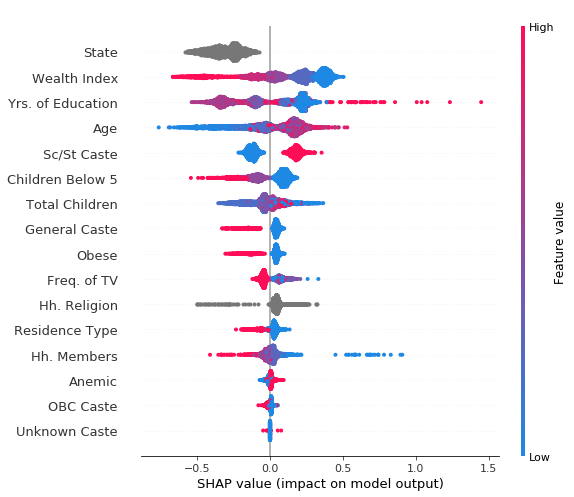


State: puducherry
Sample size: 645

state - 0.16764424967547287
wealth_index - 0.2734649824189476
hh_religion - 0.07533274304585934
women_anemic - 0.018588633553689927
obese_female - 0.09257842196173464
urban - 0.07835578456939819
freq_tv - 0.044522850276251524
age - 0.19386152436917345
years_edu - 0.21143472199959973
hh_members - 0.051581046650805026
no_children_below5 - 0.12818522971244198
total_children - 0.09390392539534889
caste_don't know - 0.00016815548692496513
caste_general - 0.05255826372340111
caste_other backward class - 0.006920677804319431
caste_sc/st - 0.1123297340480358


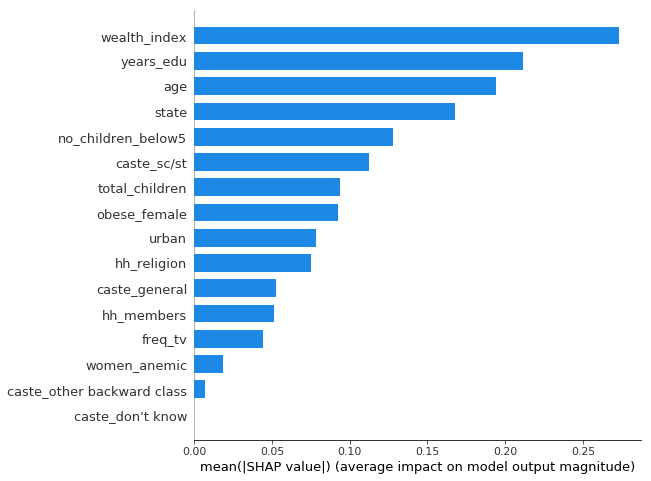

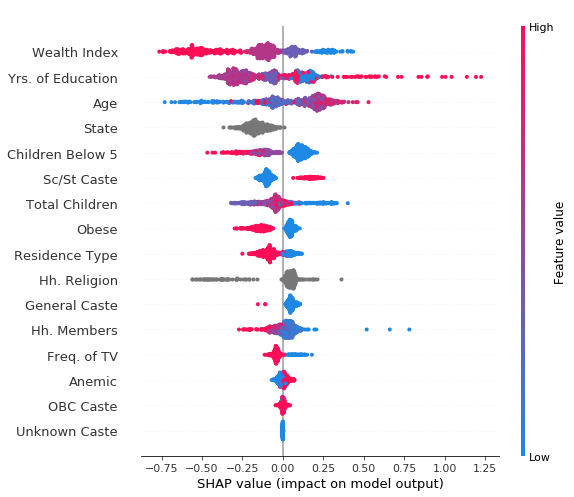


State: punjab
Sample size: 2319

state - 0.17806900504592524
wealth_index - 0.36464754151709733
hh_religion - 0.1309611686606343
women_anemic - 0.013711153188912764
obese_female - 0.07797844235106746
urban - 0.060625721983633356
freq_tv - 0.04197505641298443
age - 0.1843410163156521
years_edu - 0.23719500726845463
hh_members - 0.04443249514437853
no_children_below5 - 0.1010319957932017
total_children - 0.10475645380349487
caste_don't know - 0.0001637057557684412
caste_general - 0.101382218697801
caste_other backward class - 0.008548394676192412
caste_sc/st - 0.1368217871387178


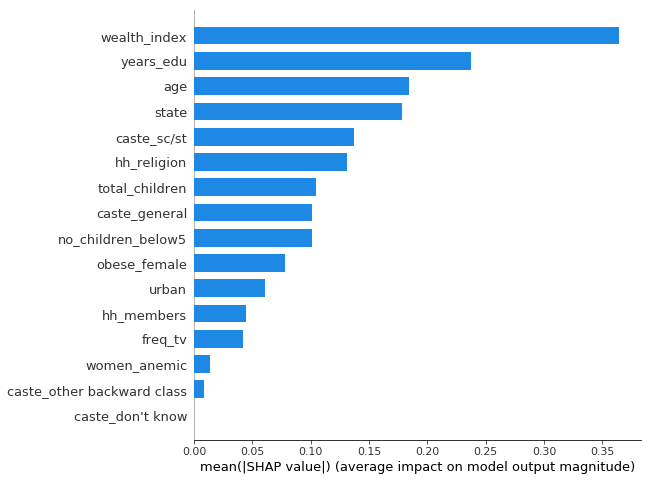

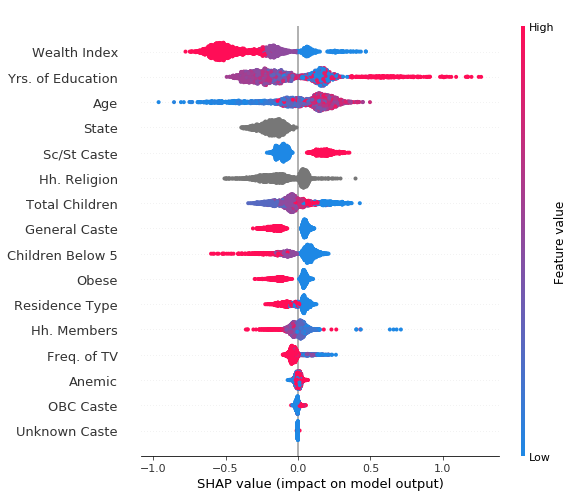


State: rajasthan
Sample size: 4556

state - 0.06898856037410851
wealth_index - 0.284876235010963
hh_religion - 0.08124075823406465
women_anemic - 0.012021303755566617
obese_female - 0.06839567773913771
urban - 0.06382860254784875
freq_tv - 0.06522569594144384
age - 0.20874929060974803
years_edu - 0.1690968804794954
hh_members - 0.04785075902615869
no_children_below5 - 0.13442280168824444
total_children - 0.08079209044302472
caste_don't know - 0.0003414684930673949
caste_general - 0.0858736958196254
caste_other backward class - 0.012283640316558004
caste_sc/st - 0.0939962043775967


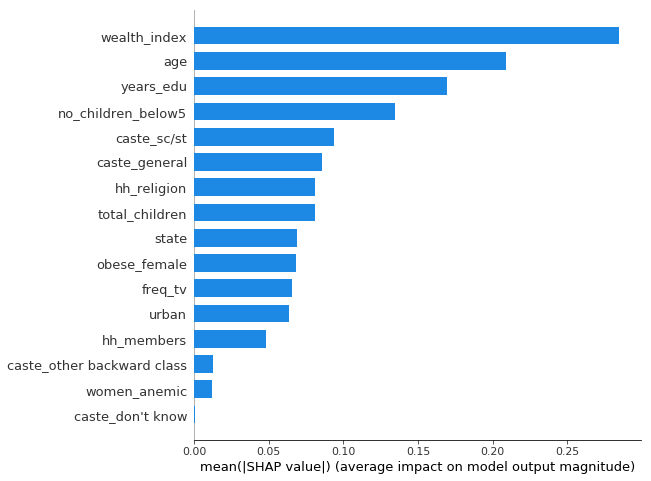

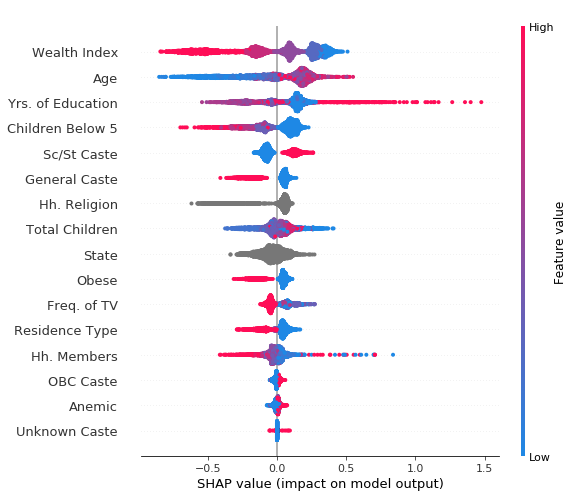


State: sikkim
Sample size: 707

state - 0.06593959585858221
wealth_index - 0.17072971797918868
hh_religion - 0.06715227591789176
women_anemic - 0.019005079627700854
obese_female - 0.09306545227720253
urban - 0.05062926720502821
freq_tv - 0.05737764906709103
age - 0.2005080024461019
years_edu - 0.1898018329992436
hh_members - 0.041727942166056776
no_children_below5 - 0.11909086558557445
total_children - 0.09731861894417643
caste_don't know - 0.00017529134509389454
caste_general - 0.0876515738051876
caste_other backward class - 0.009844094164128
caste_sc/st - 0.12075105027637975


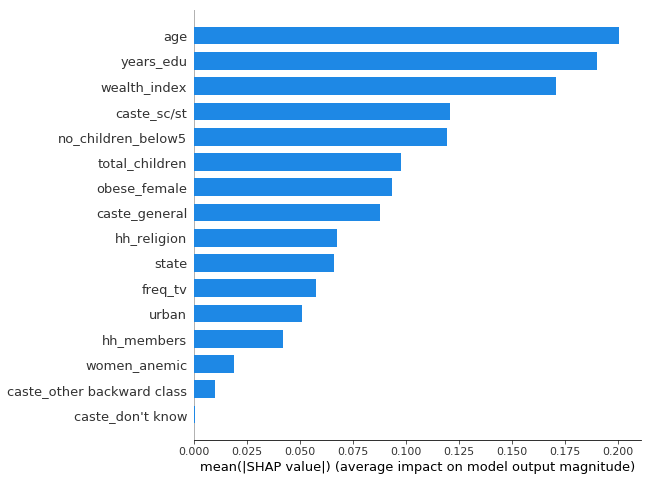

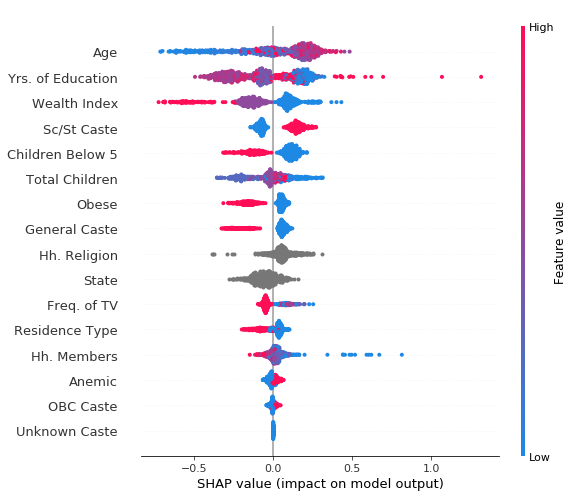


State: tamil nadu
Sample size: 4656

state - 0.18068443627078862
wealth_index - 0.25158629792726506
hh_religion - 0.07357529896355205
women_anemic - 0.013973831103629377
obese_female - 0.08111158620521962
urban - 0.09302497538989442
freq_tv - 0.03484038987717907
age - 0.2287545527071543
years_edu - 0.20128432277727618
hh_members - 0.04660315777825554
no_children_below5 - 0.14435945103832484
total_children - 0.08765462849329114
caste_don't know - 0.00017051644193630892
caste_general - 0.06290422883638996
caste_other backward class - 0.007415980192222814
caste_sc/st - 0.09150724516613258


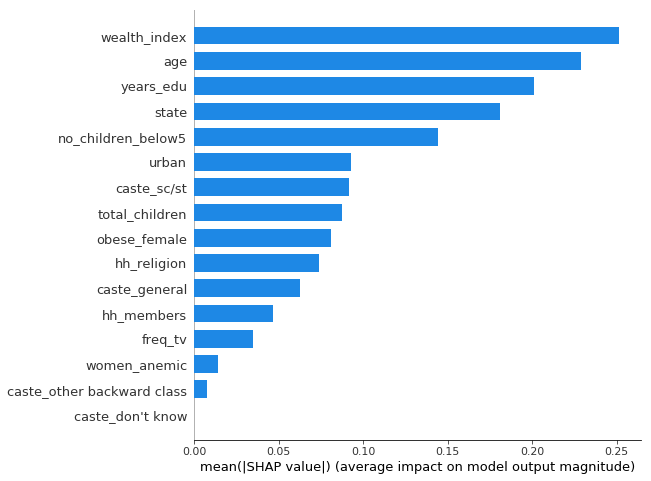

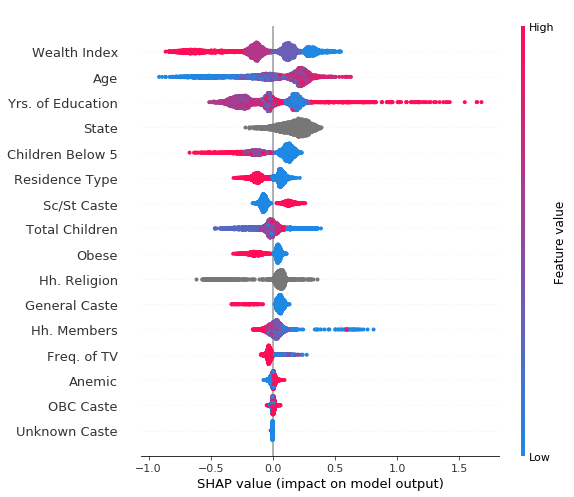


State: tripura
Sample size: 606

state - 0.0699647534847981
wealth_index - 0.2535553163016879
hh_religion - 0.05553983452463
women_anemic - 0.00826675136326738
obese_female - 0.055890334239895915
urban - 0.04512648214632951
freq_tv - 0.047560379927684845
age - 0.23050084396480383
years_edu - 0.18070398293148424
hh_members - 0.0505421912817425
no_children_below5 - 0.13566460603134192
total_children - 0.09963175216061189
caste_don't know - 0.00018714510413739082
caste_general - 0.07987316051643839
caste_other backward class - 0.006094911215573253
caste_sc/st - 0.13819922532833973


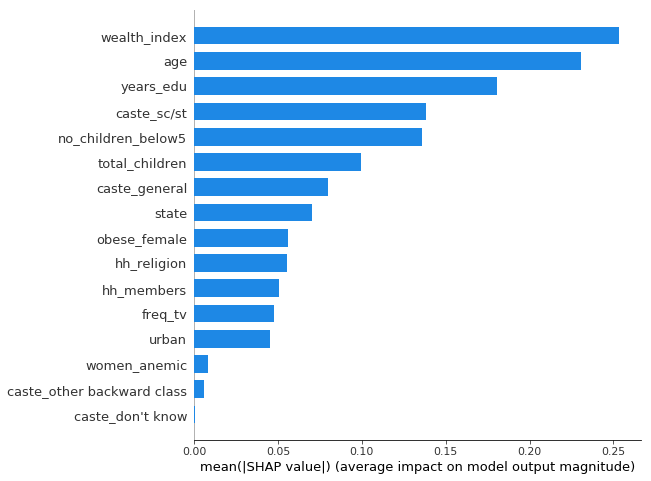

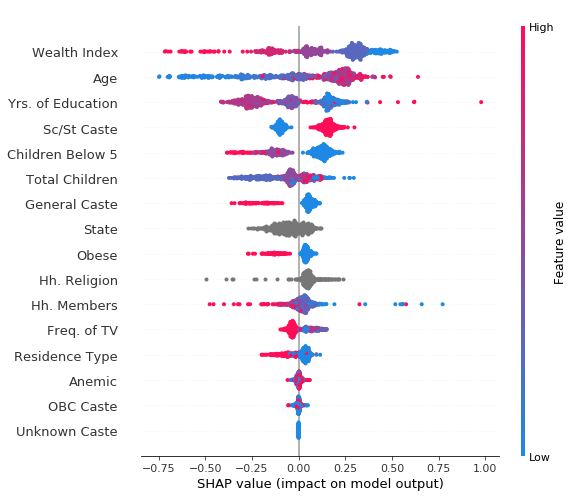


State: uttar pradesh
Sample size: 9903

state - 0.3479233442824256
wealth_index - 0.24062372684923838
hh_religion - 0.1046231982071358
women_anemic - 0.010119750717594835
obese_female - 0.06217751753182253
urban - 0.0398097172178101
freq_tv - 0.052254599169057364
age - 0.20130062181218175
years_edu - 0.17071372510172783
hh_members - 0.06428025668233377
no_children_below5 - 0.13627763582939026
total_children - 0.11655309563503284
caste_don't know - 0.00023242394153516867
caste_general - 0.0795149837988278
caste_other backward class - 0.008368642088310474
caste_sc/st - 0.11408060836886506


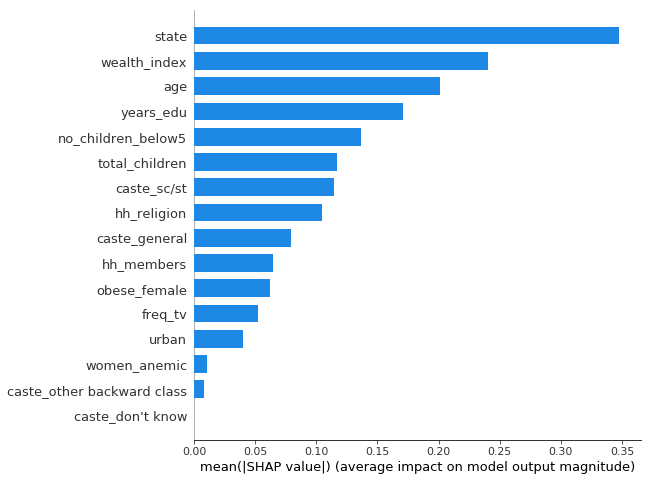

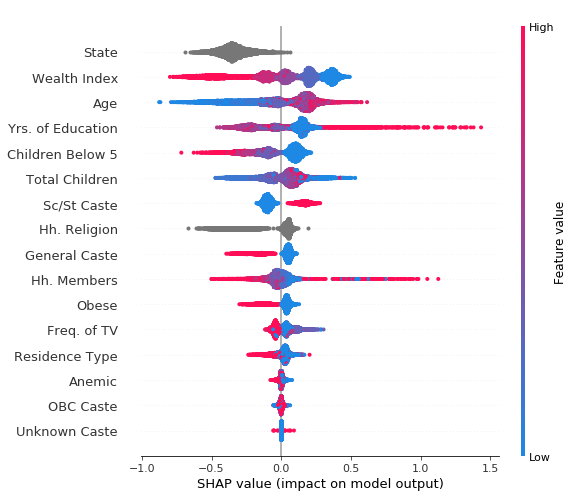


State: uttarakhand
Sample size: 1867

state - 0.33270315950266116
wealth_index - 0.2039870072627721
hh_religion - 0.07251753696714341
women_anemic - 0.01904684295912751
obese_female - 0.05754482099962636
urban - 0.04135555049875675
freq_tv - 0.04878640577959116
age - 0.19835090645500145
years_edu - 0.20089329919878884
hh_members - 0.060757609128899354
no_children_below5 - 0.12432160268042843
total_children - 0.11234776246824235
caste_don't know - 0.000310262349634214
caste_general - 0.10716445408755622
caste_other backward class - 0.009700848670380643
caste_sc/st - 0.11342956622406726


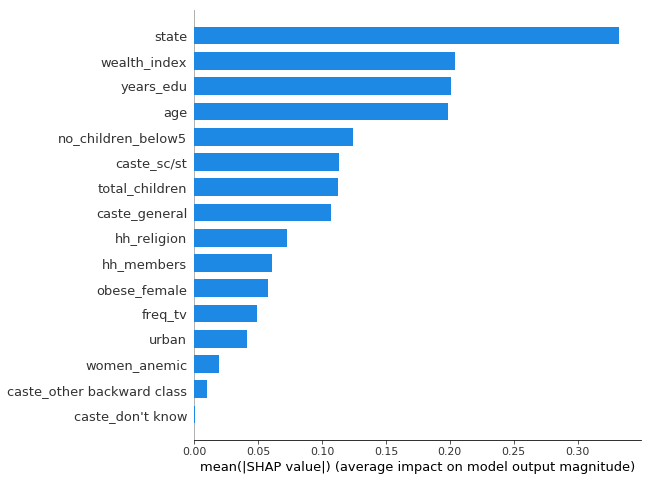

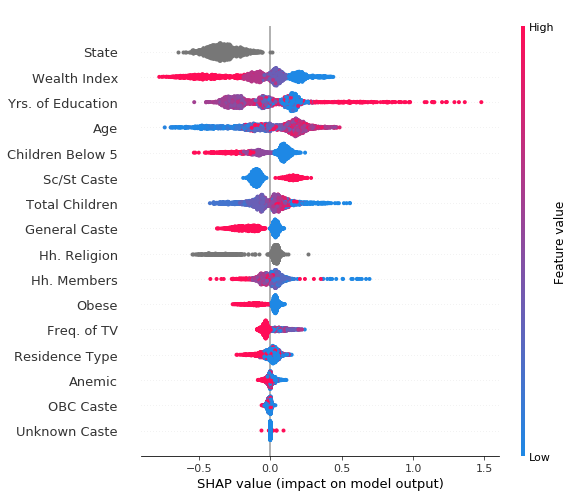


State: west bengal
Sample size: 1706

state - 0.3469214680529787
wealth_index - 0.19604971692686773
hh_religion - 0.08063314483344396
women_anemic - 0.021479463604590472
obese_female - 0.062308117642345735
urban - 0.032863350952729395
freq_tv - 0.03409735904822955
age - 0.18814779961876119
years_edu - 0.18807672080305732
hh_members - 0.07317503034979676
no_children_below5 - 0.135781546088638
total_children - 0.1075212172892572
caste_don't know - 0.0007290991296643964
caste_general - 0.09945775978176374
caste_other backward class - 0.010819404821006604
caste_sc/st - 0.13601822600694213


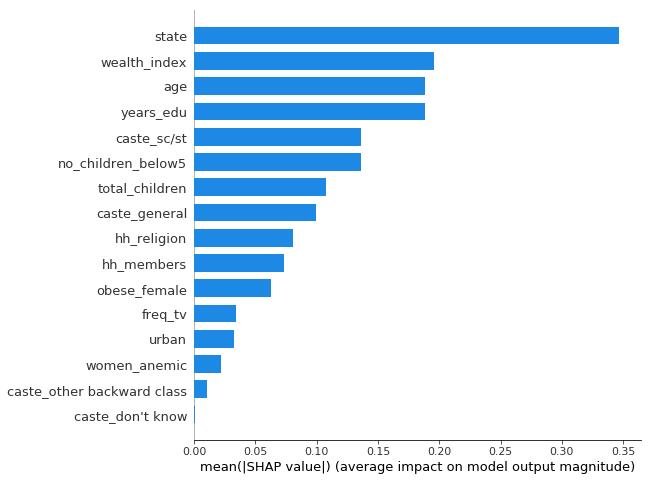

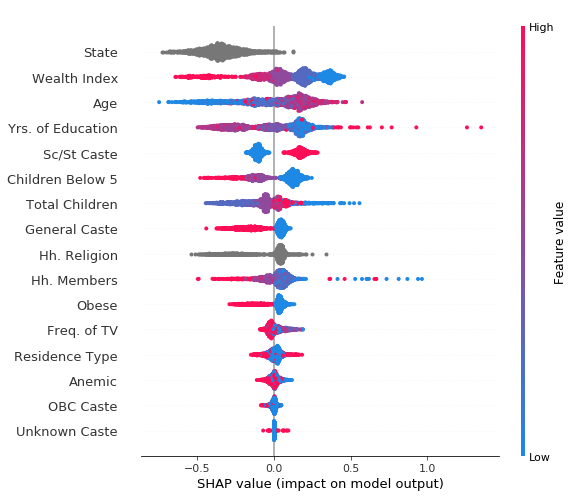


State: telangana
Sample size: 885

state - 1.0256833071083982
wealth_index - 0.29497658596434856
hh_religion - 0.09645991732912916
women_anemic - 0.0126668524463162
obese_female - 0.11067260721772118
urban - 0.19175682225954888
freq_tv - 0.03282431376426194
age - 0.22149482429069042
years_edu - 0.23984164823863136
hh_members - 0.05898481372687365
no_children_below5 - 0.12696184826756604
total_children - 0.06577641626857228
caste_don't know - 0.0005262124992428448
caste_general - 0.057690778899712115
caste_other backward class - 0.029713449774206833
caste_sc/st - 0.11668808735571061


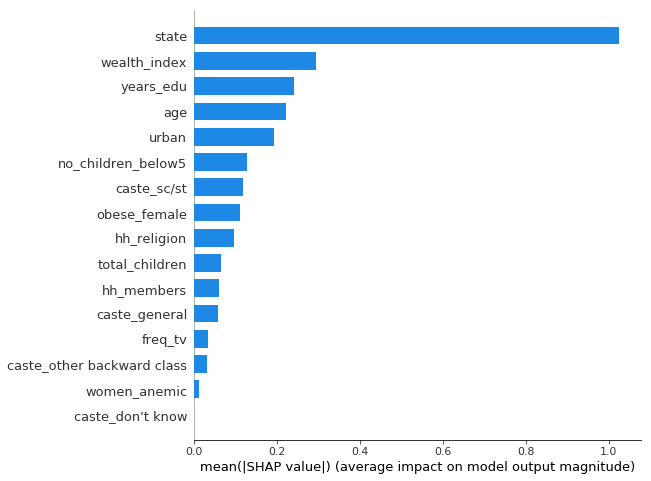

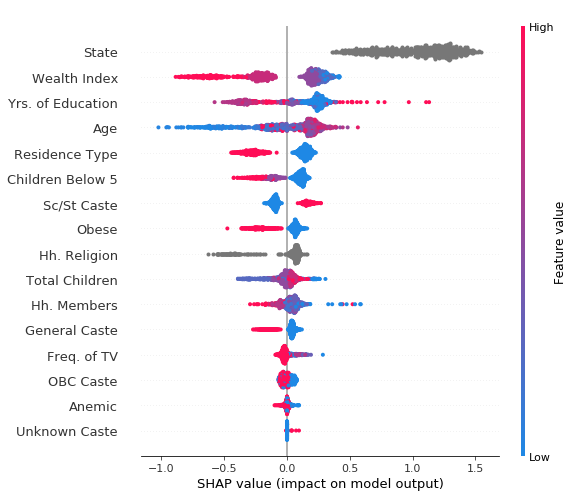

In [45]:
for state, state_display in zip(dataset.state.unique(), dataset_display.State.unique()):
    # Sample dataset by state
    dataset_sample = dataset[dataset.state==state]
    dataset_display_sample = dataset_display[dataset.state==state]
    targets_sample = targets[dataset.state==state]
    shap_values_sample = shap_values[dataset.state==state]
    
    print("\nState: {}".format(state_display))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

### SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. 

The model returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. 

Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [42]:
# Sample from dataset based on sample weights
dataset_ss = dataset.sample(10000, weights=sample_weights, random_state=random_state)
print(dataset_ss.shape)
dataset_display_ss = dataset_display.loc[dataset_ss.index]
print(dataset_display_ss.shape)

(10000, 16)
(10000, 16)


In [43]:
# Compute SHAP interaction values (time consuming)
# shap_interaction_values = explainer.shap_interaction_values(dataset_ss)
shap_interaction_values = pickle.load(open(f'res/{target_col}-{year}-shapints.obj', 'rb'))

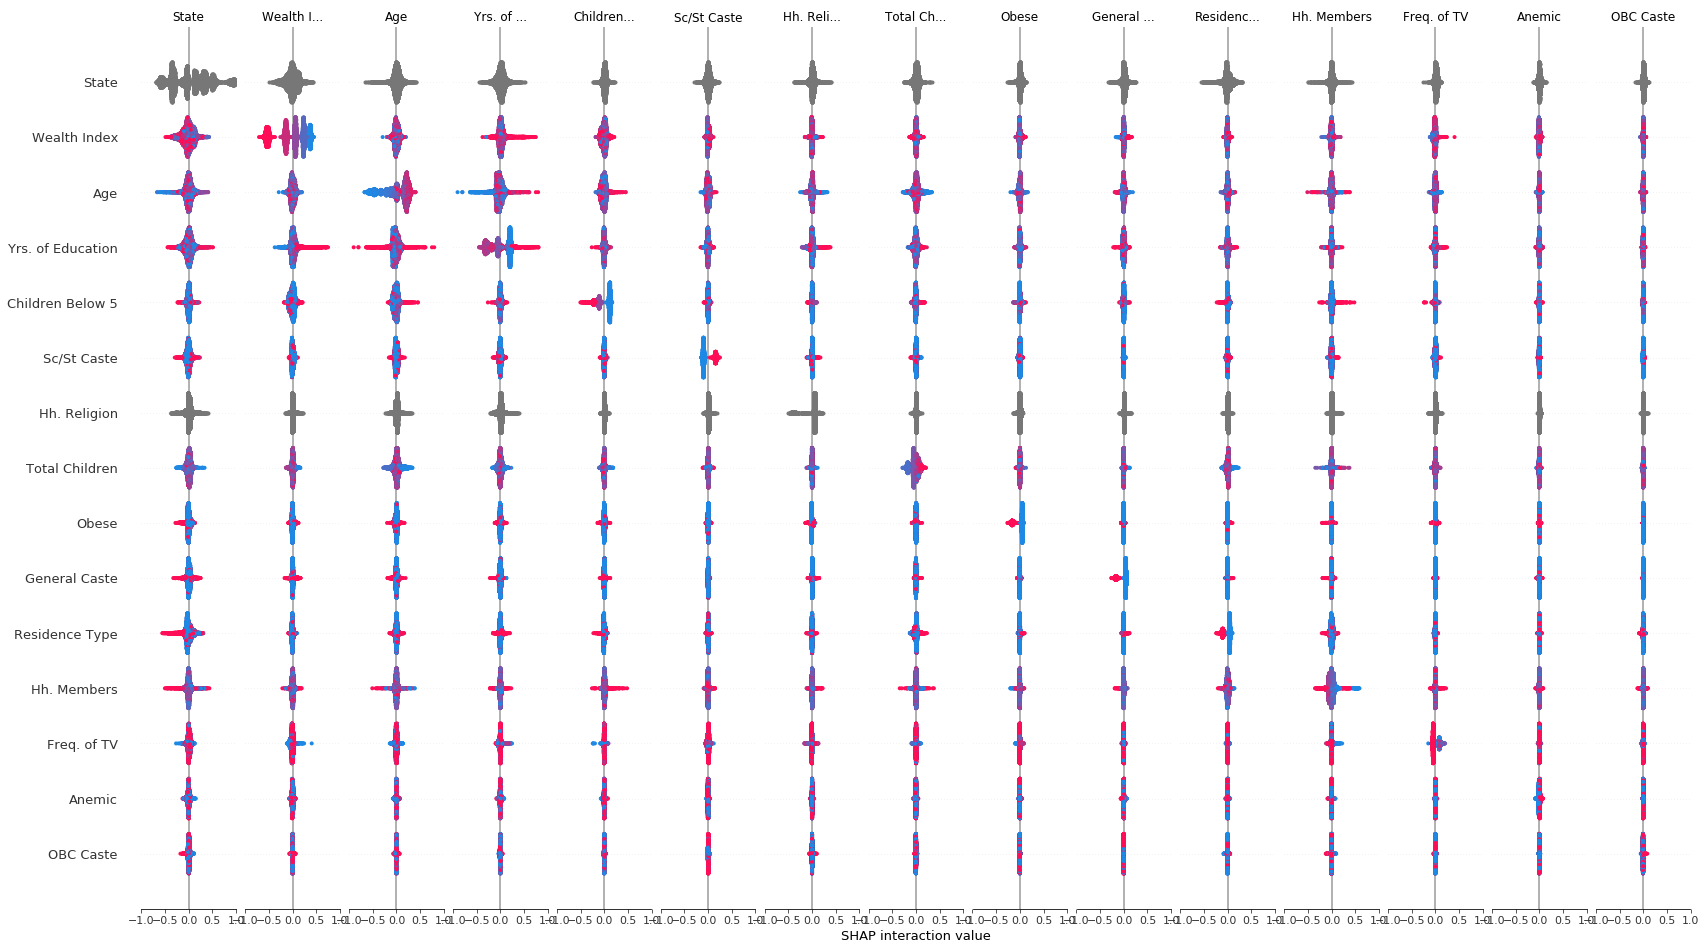

In [44]:
shap.summary_plot(shap_interaction_values, dataset_display_ss, max_display=15)

### Heatmap of SHAP Interaction Values

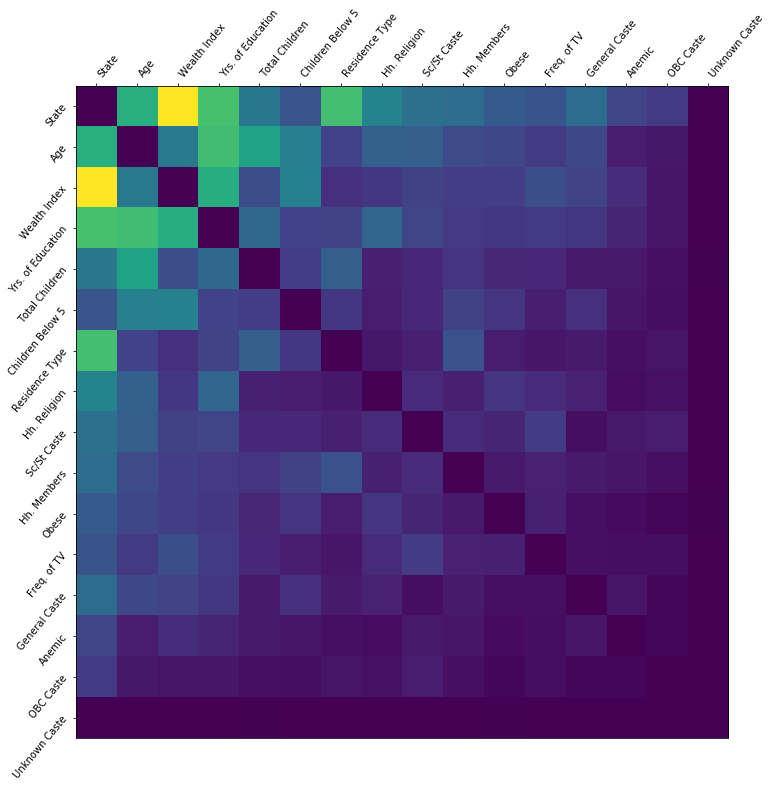

In [52]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), dataset_display_ss.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), dataset_display_ss.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

**Good example of how to infer interesting stuff from interaction values: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html**

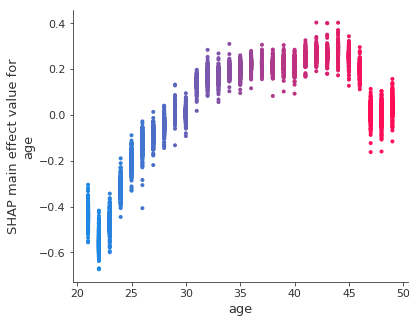

In [46]:
shap.dependence_plot(
    ("age", "age"), 
    shap_interaction_values, dataset_ss, display_features=dataset_display_ss
)

Now we plot the interaction effects involving age (and other features after that). These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above.

#### Plots for 'age'


Feature: age, Interaction Feature: age


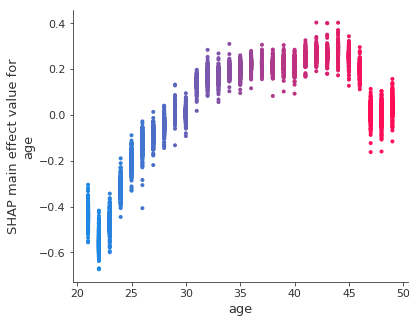


Feature: age, Interaction Feature: urban


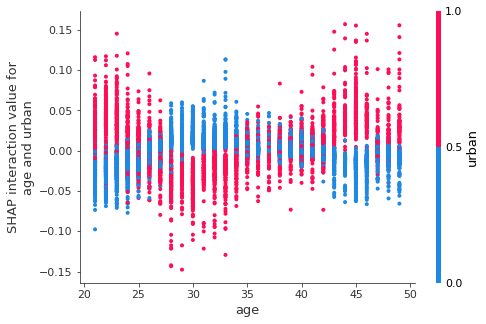


Feature: age, Interaction Feature: caste_sc/st


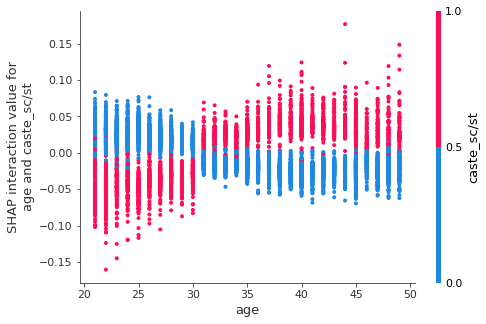


Feature: age, Interaction Feature: caste_general


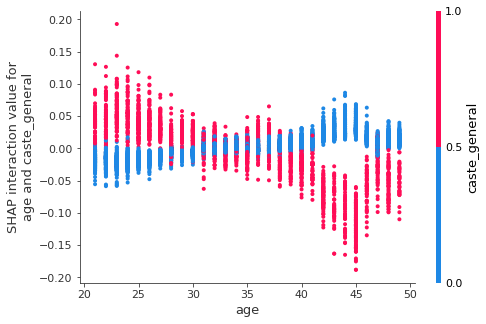


Feature: age, Interaction Feature: wealth_index


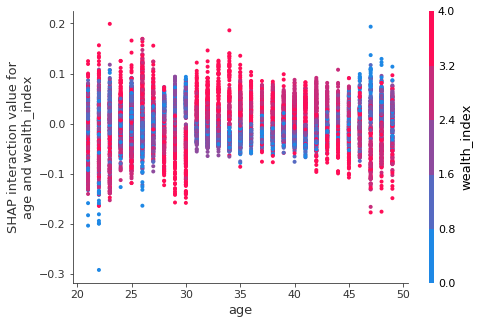


Feature: age, Interaction Feature: years_edu


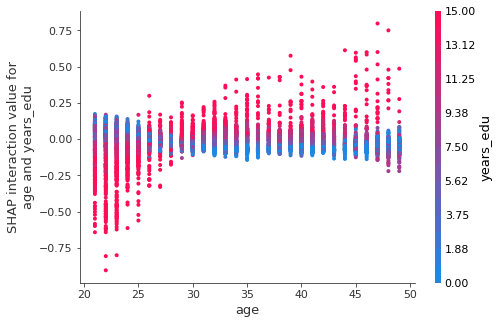


Feature: age, Interaction Feature: no_children_below5


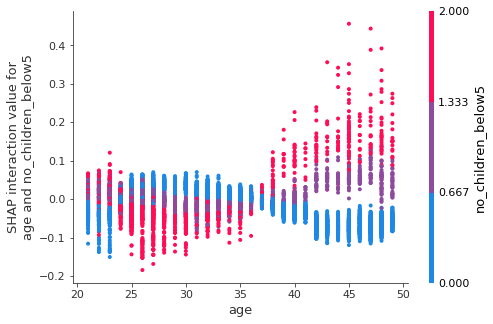


Feature: age, Interaction Feature: total_children


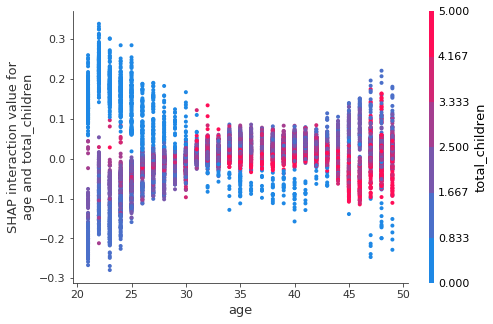

In [47]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


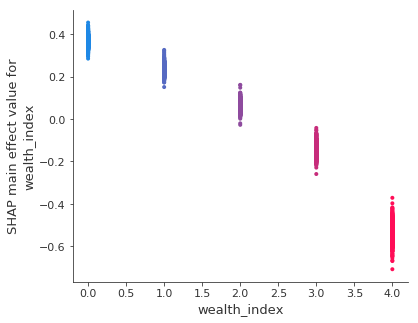


Feature: wealth_index, Interaction Feature: age


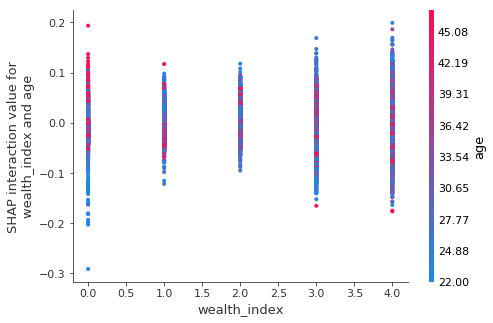


Feature: wealth_index, Interaction Feature: urban


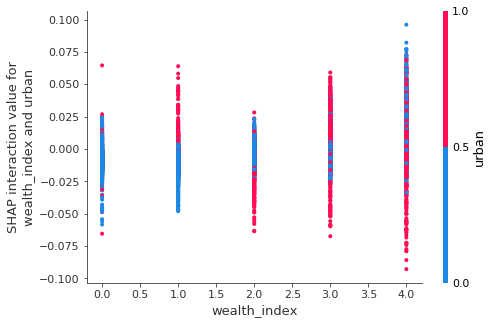


Feature: wealth_index, Interaction Feature: caste_sc/st


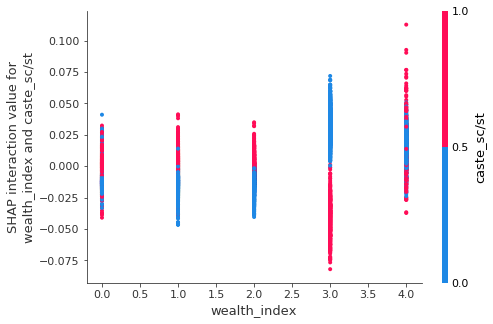


Feature: wealth_index, Interaction Feature: caste_general


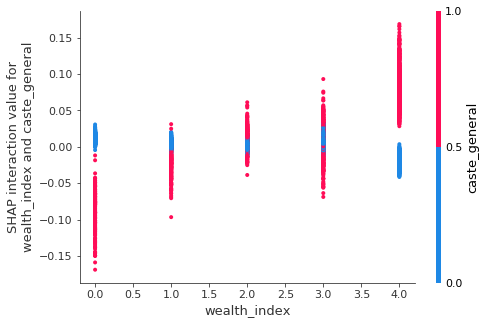


Feature: wealth_index, Interaction Feature: years_edu


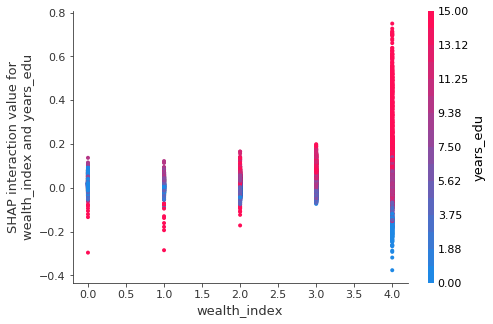


Feature: wealth_index, Interaction Feature: no_children_below5


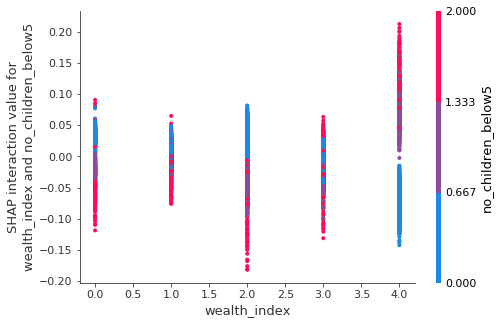


Feature: wealth_index, Interaction Feature: total_children


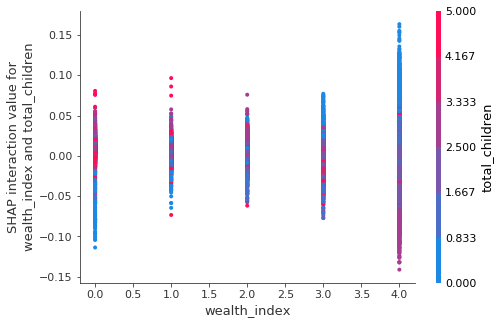

In [48]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


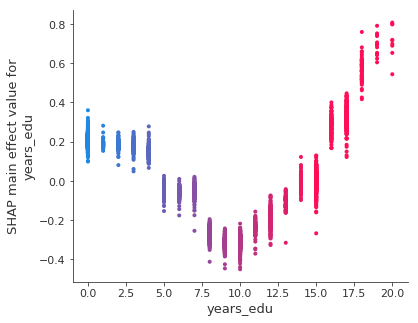


Feature: years_edu, Interaction Feature: age


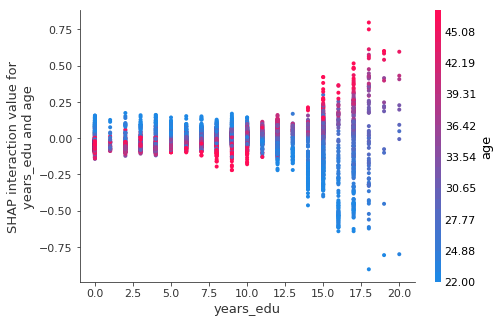


Feature: years_edu, Interaction Feature: urban


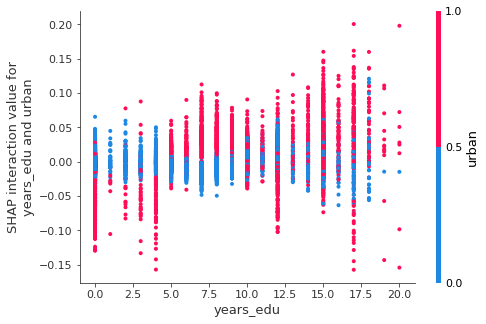


Feature: years_edu, Interaction Feature: caste_sc/st


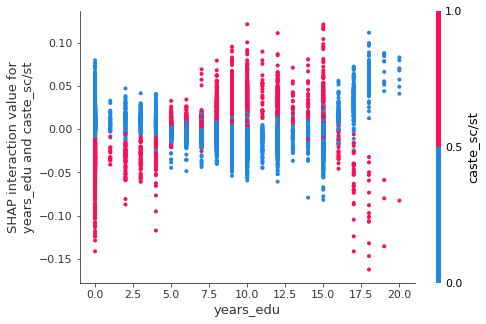


Feature: years_edu, Interaction Feature: caste_general


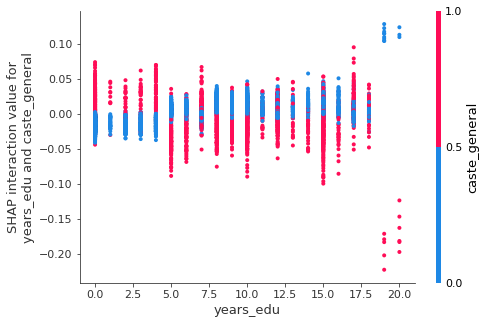


Feature: years_edu, Interaction Feature: wealth_index


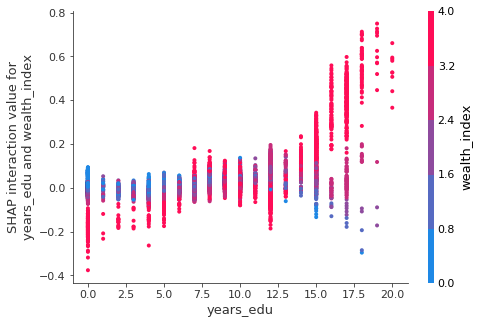


Feature: years_edu, Interaction Feature: no_children_below5


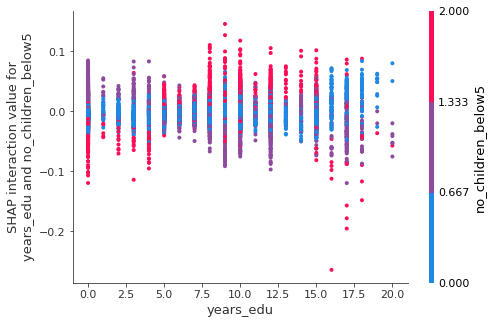


Feature: years_edu, Interaction Feature: total_children


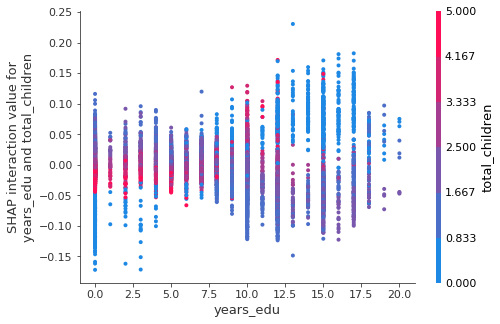

In [49]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


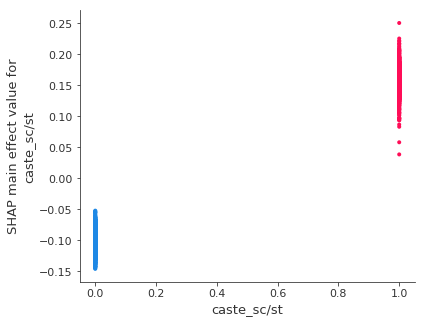


Feature: caste_sc/st, Interaction Feature: age


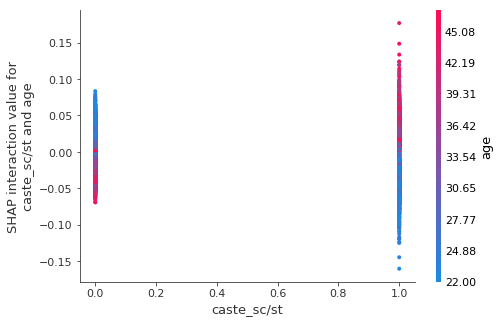


Feature: caste_sc/st, Interaction Feature: urban


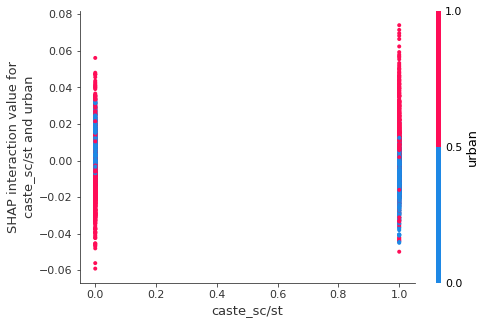


Feature: caste_sc/st, Interaction Feature: years_edu


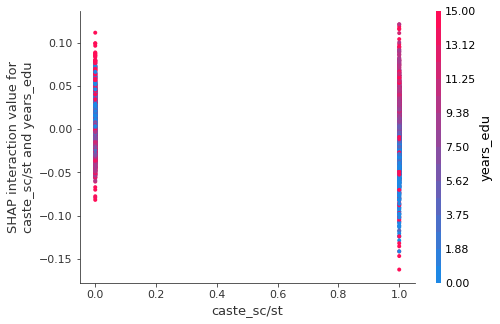


Feature: caste_sc/st, Interaction Feature: wealth_index


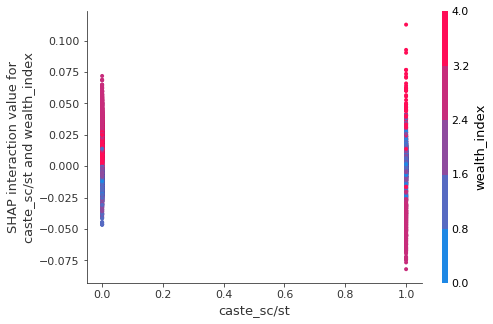


Feature: caste_sc/st, Interaction Feature: no_children_below5


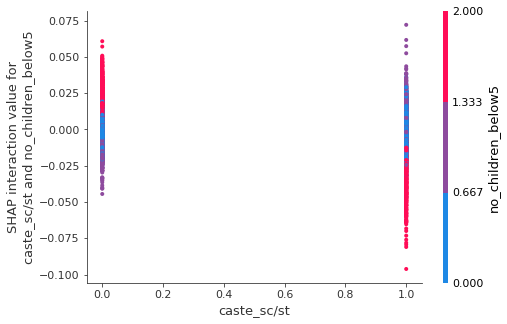


Feature: caste_sc/st, Interaction Feature: total_children


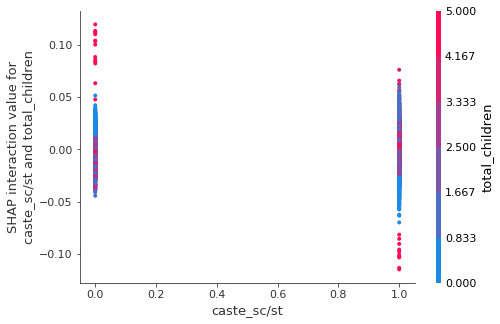

In [50]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


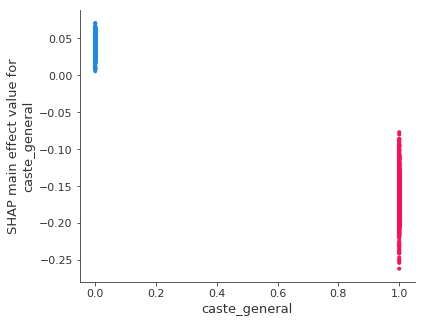


Feature: caste_general, Interaction Feature: age


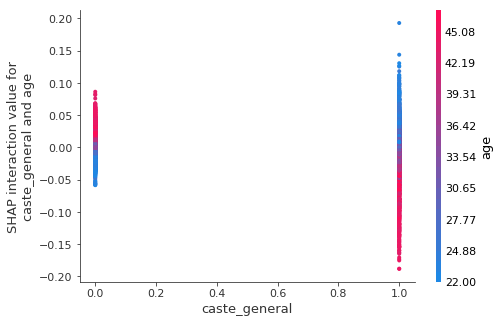


Feature: caste_general, Interaction Feature: urban


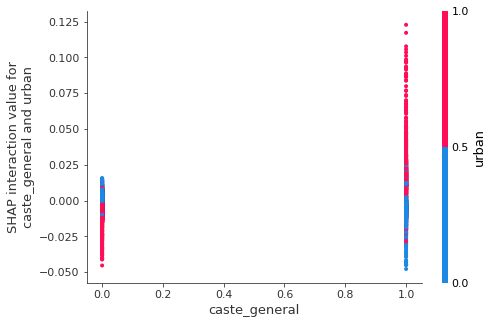


Feature: caste_general, Interaction Feature: years_edu


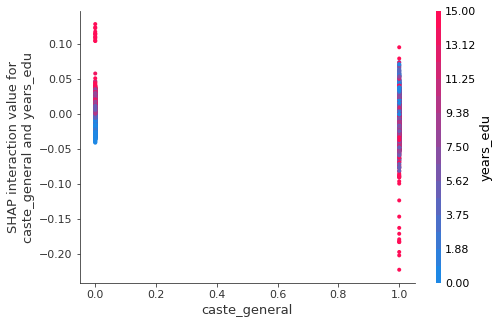


Feature: caste_general, Interaction Feature: wealth_index


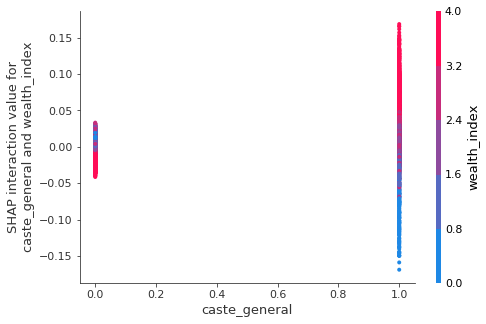


Feature: caste_general, Interaction Feature: no_children_below5


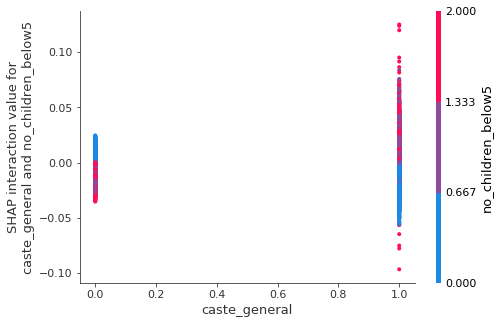


Feature: caste_general, Interaction Feature: total_children


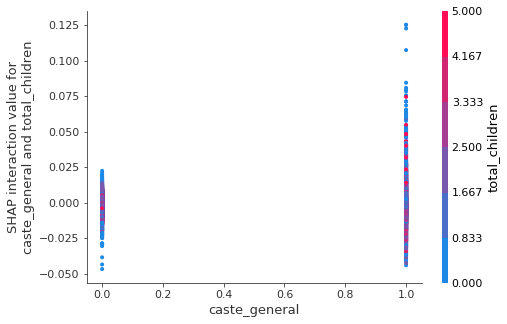

In [51]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )